# Introduction

This Jupyter notebook contains code aimed at answering 3 questions which all deal with the common theme of whether data scientists are actually different from other developers.

To be more precise, the 3 questions to be answered are as follows:
* What programming languages do data scientists use and is there any difference compared to developers in general?
* Do data scientists have different educational backgrounds than other developers?
* Does being successful as a data scientist depend upon factors than being successful as a "normal" developer?


These questions will be answered using Stack Overflow Annual Developer Survey data for the years 2017, 2018 and 2019 with the focus in general being on the latter.

Following a general CRISP-DM process this notebook starts by investigating and cleaning the data before moving on to obtaining results which only in the case of the third question will be based upon data modeling.

# Business Understanding/ Data Understanding

In the case of this analysis I started off by looking at the Stack Overflow Annual Developer Surveys for the years 2017, 2018 and 2019 before thinking of possible questions.

Being an aspiring data scientist myself I found it interesting to use this data to find out if there is some evidence in how far data scientists may differ from other developers. In that respect I found the questions of which programming languages these two groups use and what kind of educational backgrounds they have particularly. Holding a master's degree in economics myself and having mainly been exposed to Python when it comes to programming, my personal background is quite different from that of a non-data-scientist developer. Even so, I do frequent Stack Overflow essentially every day.

Finally, I thought it would be interesting to find out if data scientists are possibly satisfied with their career due to different reasons than traditional developers. 

In [3]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.feature_selection import RFE

In [9]:
# Read in Stackoverflow data for years 2017 to 2019
survey_2019 = pd.read_csv('Data_19/survey_results_public.csv', low_memory = False)
survey_2018 = pd.read_csv('Data_18/survey_results_public.csv', low_memory = False)
survey_2017 = pd.read_csv('Data_17/survey_results_public.csv', low_memory = False)


# Also read in schema files to be able to look up questions later on
schema_2019 = pd.read_csv('Data_19/survey_results_schema.csv')
schema_2018 = pd.read_csv('Data_18/survey_results_schema.csv')
schema_2017 = pd.read_csv('Data_17/survey_results_schema.csv')
schema_2017 = schema_2017.rename(index=str, columns={'Question':'QuestionText'})

# Define a simple function as in Udacity class on 'Introduction to Data Science' to be able
# to look up individual descriptions of columns contained in dataframes

def show_description(column_name, schema):
    '''
    INPUT - column name - string containing the name of the column for which you would like
                          to see the description
            schema      - the pandas dataframe containing the schema to be used for looking
                          up the description
    OUTPUT - desc - string - description of the column
    '''
    
    desc = schema[schema['Column'] == column_name]['QuestionText'].values[0]
    return desc

# Remove the respondent column from all dataframes since it offers no additional value
survey_2019 = survey_2019.drop('Respondent',axis=1)
survey_2018 = survey_2018.drop('Respondent',axis=1)
survey_2017 = survey_2017.drop('Respondent',axis=1)

## A First Look at the Data
Let us first take a short look at the data we have just imported.

In [10]:
# compare dimensions of different surveys and number of numeric and categorical columns
for survey in [survey_2019,survey_2018, survey_2017]:
    print(survey.shape)
    print(survey.select_dtypes(include='object').shape[1])
    print(survey.select_dtypes(exclude='object').shape[1])
    

# Display the columns of the 2019 data
survey_2019.columns

(88883, 84)
79
5
(98855, 128)
87
41
(51392, 153)
147
6


Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment',
       'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther',
       'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro',
       'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek',
       'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate',
       'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 

## Some Observations with Respect to Columns and Numbers of Observations

It turns out that the Stackoverflow surveys are quite different across different years with the number of questions asked ranging from 66 in 2016 to 154 in 2017. In this context it is interesting to note that the 2018 survey is quite special in so far as that roughly 1/3 of its columns were numerical while in other years there were only 5 or 6 numerical columns.

This has important implications for the subsequent data cleaning process where we will need to either encode categorical variables using dummy variables or drop them if they appear to be of little use or have too many unique values.

The number of participants also differs across years with the 2 latest surveys having a significant larger number of participants.

## A Brief Look at Relevant Columns for Questions 1 and 2

Before turning to data cleaning let us have a brief look at the columns needed to answer the first and the second question. For the sake of brevity this short overview will be limited to the 2019 data.

As for question 1 it seems reasonable to consider both "LanguageWorkedWith" (programming languages used by respondent in last year) and "LanguageDesireNextYear" (programming languages respondent would like to work with during the next year). The columns "EdLevel" (highest level of formal education) and "UndergradMajor" provide information on the respondents' educational backgrounds.

In [11]:
# A short look at the columns LanguageWorkedWith, LanguageDesireNextYear, EdLevel and and UndergradMajor
# and the respective numbers of unique values
for column in ['LanguageWorkedWith', 'LanguageDesireNextYear', 'EdLevel', 'UndergradMajor']:
    print(column)
    print(survey_2019[column].value_counts(normalize=True).head())
    print('Number of unique values for '+column+' :'+str(survey_2019[column].nunique()))
    print('\n')

LanguageWorkedWith
HTML/CSS;JavaScript;PHP;SQL              0.016935
C#;HTML/CSS;JavaScript;SQL               0.016147
HTML/CSS;JavaScript                      0.014240
C#;HTML/CSS;JavaScript;SQL;TypeScript    0.011305
Java                                     0.010666
Name: LanguageWorkedWith, dtype: float64
Number of unique values for LanguageWorkedWith :20098


LanguageDesireNextYear
Python                            0.014699
HTML/CSS;JavaScript               0.008289
HTML/CSS;JavaScript;TypeScript    0.007706
C#                                0.007219
Java                              0.006945
Name: LanguageDesireNextYear, dtype: float64
Number of unique values for LanguageDesireNextYear :27259


EdLevel
Bachelor’s degree (BA, BS, B.Eng., etc.)                                              0.452992
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           0.226519
Some college/university study without earning a degree                                0.12156

As we can see above, only the two columns we will need to consider for answering question 2 are "well-behaved". The columns containing information on programming languages respondents have used or would like to use are quite messy because, as one would expect, most respondents used or would like to use several different languages. A large number of unique combinations and different orders in which respondents mentioned the languages lead to an extremely large number of unique values. We will need to find a way to deal with that. 

# Data Cleaning

## Overview

Before starting to clean our data it is important to think about how we will need to clean the data for the different questions. Note that out of the three questions only the third one requires modelling.  

## General

In order to be able to distinguish between the two groups (data scientists and non data scientists) we will need to create two dataframes for each analysis based upon which group the respondents belong to.


## Question 1

As we saw above, there are way too many unique values in the two columns dealing with the programming languages respondents are using or would like to use. We will need to write a function that creates a new column for each language with either 1 or 0 depending upon whether the respondent uses the language. Note that some languages are rather "obscure" and will not be included in the analysis.

In order to avoid issues here we will need to only consider those respondents who provided information on the programming languages they used or would like to use.


## Question 2

Answering the question whether data scientists differ in their educational background from other developers will not require any particularly difficult data wrangling. It will be sufficient to just compare the distributions of the relevant columns since they are already in a format which can easily be dealt with. 


## Question 3

Finally, the question whether the determinants of success differ between data scientists and other developers will require the largest amount of data wrangling since the data will be passed on to a machine learning algorithm. In particular, all NANs will have to be dealt with and all categorical values which are kept will need to be represented numerically via one-hot encoding. 

## Data Cleaning for Questions 1 and 2

In [12]:
# Split 2017, 2018 and 2019 data into two dataframes for data scientists and other developers.
# Note here that the 2017 data contains not only a 'DevType' column, but also a "NonDeveloperType"
# column and hence data scientists can be either identified using the "DeveloperType" or "NonDeveloperType"
# for the 2017 data

def split_df(df,col,value):
    '''
    Splits a dataframe into 2 based upon whether values in a column match
    a specified value
    INPUT:
    df - the pandas dataframe containing the data to be split
    col - the column to search for the value for the split
    value - the value to search for
    
    OUTPUT:
    split_1, split_2 - the 2 dataframes the original dataframe was split into   
    '''
    # Drop NaNs to avoid issues
    data = df.dropna(subset=[col],axis=0)
    # Split dataframes into 2
    split_1 = data[data[col].str.contains(value)]
    split_2 = data[~data[col].str.contains(value)]
    return split_1, split_2

data_scientists_2019, other_devs_2019 = split_df(survey_2019,'DevType','Data scientist')
data_scientists_2018, other_devs_2018 = split_df(survey_2018,'DevType','Data scientist')

# split 2017 dataframe into respondents who gave a 'DeveloperType' and those who gave a 'NonDeveloperType' 
data_scientists_2017, other_devs_2017 = split_df(survey_2017,'DeveloperType','Data scientist')
data_scientists_nondev_2017, other_nondevs_2017 = split_df(survey_2017,'NonDeveloperType','Data scientist')

# Check dimensions of data after splitting
print(data_scientists_2019.shape)
print(other_devs_2019.shape)
print(data_scientists_2018.shape)
print(other_devs_2018.shape)
print(data_scientists_2017.shape)
print(data_scientists_nondev_2017.shape)
print(other_devs_2017.shape)
print(other_nondevs_2017.shape)

(6460, 84)
(74875, 84)
(7088, 128)
(85010, 128)
(3045, 153)
(1100, 153)
(33080, 153)
(3790, 153)


Using the above function we divided the data into data scientists and other developers for 2017, 2018 and 2019. In addition for the 2017 data, we also created dataframes for non-developer data scientists and other non-developers. Printing the dimensions of the resulting dataframes can be thought of as a simple sanity check.

Splitting the data like this enables us to compare data scientists and other developers. As far as question 2 is concerned, this is essentially all we need do in terms of preprocessing. For question 1 we still need to apply a function (defined in the next cell) to obtain counts of the respondents who used or want use each of the programming languages they were asked about in the Stackoverflow surveys.

In [13]:
# Define function to be used for extracting the counts of values from one column where the value of another column
# contains one of the values defined in a list; adapted from Udacity class "Introduction to Data Science" to use
# SIMD for improved performance instead of looping through individual rows

def total_count(df, col, look_for, norm = True, col_name = None):
    '''
    Creates and Returns a new dataframe containing the counts 
    of each value contained in the list look_for in the strings in col
    INPUT:
    df - the pandas dataframe you want to search
    col - the column name you want to look through
    look_for - a list of strings you want to search for in each row of df[col]
    norm - boolean determining whether normalised values, i.e. relative frequencies
           are returned, defaults to True
    col_name - (optional) string containing replacing name of column showing
               relative or absolute counts (would otherwise be named either
               counts for absolute counts or relative counts for relative counts)
    OUTPUT:
    new_df - a dataframe of each look_for with the (relative) count of how often it shows up
    '''
    data = df[col].value_counts(normalize=norm).reset_index()
    new_df = defaultdict(int)
    # loop through list of values to look for
    for val in look_for:
        # Extract value count by taking sum of values contained in col2 
        # of filtered df where col1 contains the string defined in val
        value_count_df = data[data['index'].str.contains(val)]
        # Account for the fact that list values may contain \ to escape
        # special characters and remove these \ to obtain correct names
        new_df[val.replace("\\","")] = value_count_df[col].sum()
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = ['index', col]
    new_df.sort_values(col, ascending=False, inplace=True)
    
    if col_name == None:
        if norm == True:
            col_name = 'relative counts'
        else:
            col_name = 'counts'
            
    new_df.rename(index=str, columns = {col:col_name,'index':col}, inplace = True)
    new_df = new_df.set_index(col)
    return new_df

# Define list containing languages participants of the surveys were asked about
# \ is used here to escape certain special characters such as #
# Let us skip over some more obscure languages, also to prevent them from becoming
# important predictors in question 3

languages_list = ['Assembly','Bash\/Shell\/PowerShell','C','C\+\+','C\#', 
                  'Go', 'HTML\/CSS','Java','JavaScript','Objective-C','PHP','Python',
                  'R','Ruby','Rust','Scala','SQL','Swift','TypeScript','VBA']

# Obtain results for both data scientists and other developers for 2017, 2018 and 2019

def two_counts(df,col1,col2,look_for,norm=True, col_name_1 = None, col_name_2=None):
    '''
    Helper function that calls total_count twice for different columns, but
    with same list and returns the resulting 2 dataframes
    INPUT:
    df - pandas dataframe containing the 2 columns
    col1 - first column to look through for values contained in list
    col2 - second column to look through for values contained in list
    look_for - a list of strings you want to search for in each row of df[col]
    norm - boolean determining whether normalised values, i.e. relative frequencies
           are returned, defaults to True
    col_name_1, col_name_2 - new column names for original columns col1 and col2;
                             defaults to None
    OUTPUT:
    df_col1 - result of calling total_count using df and col1 as the column
    df_col2 - result of calling toal_count using df and col2 as the column
    '''       
    df_col1 = total_count(df,col1,look_for,norm, col_name_1)
    df_col2 = total_count(df,col2,look_for,norm, col_name_2)
    return df_col1, df_col2

# Apply language_counts to all previously derived dataframes to obtain the data needed for the analysis of
# question 1 and use year of data as col_name to prepare data for subsequent use in plotting

lang_worked_2019_ds, lang_desired_2019_ds = two_counts(data_scientists_2019,'LanguageWorkedWith',
                                                       'LanguageDesireNextYear',languages_list,
                                                       col_name_1 = '2019', col_name_2='2019')
lang_worked_2019_other, lang_desired_2019_other = two_counts(other_devs_2019,'LanguageWorkedWith',
                                                             'LanguageDesireNextYear', languages_list,
                                                             col_name_1='2019', col_name_2='2019')

lang_worked_2018_ds, lang_desired_2018_ds = two_counts(data_scientists_2018,'LanguageWorkedWith',
                                                       'LanguageDesireNextYear',languages_list,
                                                       col_name_1 = '2018', col_name_2='2018')
lang_worked_2018_other, lang_desired_2018_other = two_counts(other_devs_2018,'LanguageWorkedWith',
                                                            'LanguageDesireNextYear', languages_list,
                                                             col_name_1 = '2018', col_name_2='2018')

lang_worked_2017_ds, lang_desired_2017_ds = two_counts(data_scientists_2017,'HaveWorkedLanguage',
                                                       'WantWorkLanguage',languages_list, 
                                                       col_name_1 = '2017', col_name_2='2017')
lang_worked_2017_other, lang_desired_2017_other = two_counts(other_devs_2017,'HaveWorkedLanguage',
                                                                 'WantWorkLanguage', languages_list,
                                                             col_name_1 = '2017',col_name_2='2017')

lang_worked_2017_ds_non_dev, lang_desired_2017_ds_non_dev = two_counts(data_scientists_nondev_2017,
                                                                       'HaveWorkedLanguage','WantWorkLanguage', 
                                                                       languages_list, col_name_1 = 'Worked with',
                                                                       col_name_2='Want to work with')

lang_worked_2017_non_dev, lang_desired_2017_non_dev = two_counts(other_nondevs_2017,'HaveWorkedLanguage',
                                                                 'WantWorkLanguage', languages_list, col_name_1 = 'Worked with',
                                                                 col_name_2='Want to work with')

In order to make this data easily usable for the plots necessary to answer question 1 we should concatenate the individual dataframes containing the relative counts to 4 different dataframes, one for each of the groups for which we have data available:
* data scientists (who are also developers)
* non-data scientist developers
* non-developer data scientists (data only available for 2017)
* non-developers (again, only data available for 2017)

In [17]:
# Concatenate dataframes as described above to subsequently use them for plots to answer question 2

col_name = 'relative counts'

# For developer data concatenate data for all three years
dev_ds_language_worked = pd.concat([lang_worked_2019_ds,lang_worked_2018_ds,lang_worked_2017_ds], axis = 1)
dev_ds_language_desired = pd.concat([lang_desired_2019_ds, lang_desired_2018_ds, lang_desired_2017_ds], axis = 1)
dev_non_ds_language_worked = pd.concat([lang_worked_2019_other,lang_worked_2018_other,lang_worked_2017_other], axis = 1)
dev_non_ds_language_desired = pd.concat([lang_desired_2019_other, lang_desired_2018_other, lang_desired_2017_other], axis = 1)

# For non-developer data concatenate languages respondents have worked with and want to work so we will later only
# need two graphs to have a closer look at this specific subset
non_dev_ds_languages = pd.concat([lang_worked_2017_ds_non_dev, lang_desired_2017_ds_non_dev], axis = 1)
non_dev_languages = pd.concat([lang_worked_2017_non_dev, lang_desired_2017_non_dev], axis = 1)

# Have a short look at one of the dataframes with multi-year data to check whether it is as expected
print(dev_ds_language_worked.sort_values('2019', ascending = False))

# Also have a short look at the non-developer data
print(non_dev_ds_languages.sort_values('Worked with', ascending = False))


                           2019      2018      2017
Python                 0.801658  0.767830  0.518584
C                      0.719224  0.753800  0.591593
Java                   0.649930  0.698680  0.747345
SQL                    0.590490  0.584767  0.622124
JavaScript             0.519162  0.550359  0.610177
HTML/CSS               0.509620  0.000000  0.000000
Bash/Shell/PowerShell  0.449554  0.000000  0.000000
R                      0.370249  0.410055  0.257522
C++                    0.323166  0.365626  0.300442
C#                     0.228844  0.253382  0.338496
PHP                    0.187392  0.223818  0.279204
TypeScript             0.133896  0.105061  0.098230
Assembly               0.097450  0.106564  0.066372
Scala                  0.095573  0.120929  0.103097
Go                     0.088065  0.092033  0.071681
VBA                    0.076646  0.072657  0.075221
Ruby                   0.066635  0.086521  0.098230
Swift                  0.051150  0.064306  0.067257
Objective-C 

C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=Tr

Let us also create similar dataframes for the education related columns, i.e. FormalEducation/EdLevel (highest level of formal education obtained) and UndergradMajor/ MajorUndergrad. Note that before we can take care of this we need to make sure that the answers for the 2019 and the 2018 data on the one hand and the 2017 data line up where possible. 

In [18]:
 # Use dictionaries to ensure that the data for the different years lines up where possible
formed_mapping_19_18 = {'Bachelor’s degree (BA, BS, B.Eng., etc.)':'Bachelor\'s degree',
                        'Master’s degree (MA, MS, M.Eng., MBA, etc.)': 'Master\'s degree',
                        'Other doctoral degree (Ph.D, Ed.D., etc.)':'Doctoral degree', 
                        'Professional degree (JD, MD, etc.)':'Professional degree', 
                        'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':
                        'Secondary school', 'Some college/university study without earning a degree':
                        'Some university study', 'Computer science, computer engineering, or software engineering':
                        'Computer sc./eng., software eng.','I never completed any formal education':'No formal education'}

formed_mapping_17 = {'Some college/university study without earning a bachelor\'s degree':
                     'Some university study', 'I never completed any formal education':'No formal education'}

major_mapping_19_18 = {'A business discipline (ex. accounting, finance, marketing)':'A business discipline',
                       'A health science (ex. nursing, pharmacy, radiology)':'A health science',
                       'A humanities discipline (ex. literature, history, philosophy)':'A humanities discipline',
                       'A natural science (ex. biology, chemistry, physics)':'A natural science', 
                       'Another engineering discipline (ex. civil, electrical, mechanical)':'Another engineering discipline', 
                       'A social science (ex. anthropology, psychology, political science)':'A social science', 
                       'Fine arts or performing arts (ex. graphic design, music, studio art)': 'Fine arts or performing arts',
                       'Information systems, information technology, or system administration':
                       'Information systems/techn./ sys. admin.',
                       'Computer science, computer engineering, or software engineering':
                       'Computer sc./eng., software eng.'}

major_mapping_17 = {'A non-computer-focused engineering discipline':'Another engineering discipline',
                    'Information technology,networking, or system administration':
                    'Information systems,information technology, or system administration',
                    'Computer science or software engineering':'Computer sc./eng., software eng.',
                    'Computer engineering or electrical/electronics engineering': 'Computer/ electrical/ electronics eng.',
                    'Information technology, networking, or system administration':
                    'Information techn./ networking, sys.admin.'}

for data in [data_scientists_2019, other_devs_2019]:
    data['EdLevel'] = data['EdLevel'].replace(formed_mapping_19_18)
    data['UndergradMajor'] = data['UndergradMajor'].replace(major_mapping_19_18)
    
for data in [data_scientists_2018, other_devs_2018]:
    data['FormalEducation'] = data['FormalEducation'].replace(formed_mapping_19_18)
    data['UndergradMajor'] = data['UndergradMajor'].replace(major_mapping_19_18)
        
for data in [data_scientists_2017, other_devs_2017]:
    data['FormalEducation'] = data['FormalEducation'].replace(formed_mapping_17)
    data['MajorUndergrad'] = data['MajorUndergrad'].replace(major_mapping_17)
    

In [19]:
# Obtain value counts for all years for both variables and both groups
# By using a simple function
def merge_three_value_counts(df1,df2,df3,col1,col2,col3,ren1,ren2,ren3, norm = True):
    '''
    Creates and Returns a new dataframe containing the concatenated value counts 
    for the three columns (assumed to be identical, but with possibly different names)
    from the three dataframes passed in
    INPUT:
    df1, df2, df3 - the pandas dataframes for which to obtain value counts
    col1, col2, col3 - names of the columns for which value counts are obtained
    ren1,ren2,ren3 - names to be used for renaming the original columns
    norm - boolean determining whether normalised values, i.e. relative frequencies
           are returned, defaults to True
    OUTPUT:
    new_df - a dataframe containing the concatenated value counts of all 3 dataframes
             passed in as input
    '''
    vc_1 = pd.DataFrame(df1[col1].value_counts(normalize = norm))
    vc_1.rename(index= str, columns = {col1:ren1},inplace=True)
    vc_2 = pd.DataFrame(df2[col2].value_counts(normalize = norm))
    vc_2.rename(index=str, columns = {col2:ren2}, inplace=True)
    vc_3 = pd.DataFrame(df3[col3].value_counts(normalize = norm))
    vc_3.rename(index = str, columns={col3:ren3}, inplace=True)
    new_df = pd.concat([vc_1,vc_2,vc_3], axis = 1)
    return new_df
    
ds_formed = merge_three_value_counts(data_scientists_2019, data_scientists_2018, data_scientists_2017,'EdLevel',
                                     'FormalEducation','FormalEducation','2019','2018','2017')
other_devs_formed =  merge_three_value_counts(other_devs_2019, other_devs_2018, other_devs_2017,'EdLevel',
                                     'FormalEducation','FormalEducation','2019','2018','2017')

ds_majors = merge_three_value_counts(data_scientists_2019, data_scientists_2018, data_scientists_2017,'UndergradMajor',
                                     'UndergradMajor','MajorUndergrad','2019','2018','2017')

other_devs_majors = merge_three_value_counts(other_devs_2019, other_devs_2018, other_devs_2017,'UndergradMajor',
                                             'UndergradMajor','MajorUndergrad','2019','2018','2017')

# Have a short look at the results to check if they match expectations
print(ds_formed.sort_values('2019', ascending = False))
print('\n')
print(ds_majors.sort_values('2019', ascending = False))

                               2019      2018      2017
Master's degree            0.361168  0.344837  0.308046
Bachelor's degree          0.354889  0.350995  0.384236
Doctoral degree            0.122430  0.113705  0.090312
Some university study      0.066081  0.077760  0.117570
Secondary school           0.052739  0.064442  0.044335
Associate degree           0.016010  0.014177       NaN
Professional degree        0.011615  0.014607  0.018391
Primary/elementary school  0.009732  0.013891  0.006240
No formal education        0.005337  0.005585  0.019376
I prefer not to answer          NaN       NaN  0.011494


                                                2019      2018      2017
Computer sc./eng., software eng.            0.525901  0.530085  0.536507
Mathematics or statistics                   0.128473  0.112599  0.074803
A natural science                           0.115094  0.112276  0.071582
Another engineering discipline              0.095712  0.105178  0.045812
Information syste

C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Briefly note that the categories could be mostly matched across the three years or more precisely 2019 and 2018 (where possible answers were identical) and 2017. There is one notable exception in terms of majors. In 2019 and 2018 computer engineering is lumped together with computer science and software engineering while in 2017 it was included in a category with eletrical/ electronic engineering. Even so, I decided to keep the answer and treat cases where respondents replied with "computer science, or software engineering" as belonging to the most recent answer.

With all these steps we now have the data needed to answer questions 1 and 2. Before finally moving on to answering the questions using our data we will need to prepare our data for question 3.

## Data Cleaning and Preparation for Question 3 

As mentioned above, preparing the data for question 3 is the most challenging insofar as that our data may only contain numeric values. We will also need to get rid of all NaNs whether through dropping affected columns or rows or via replacing missing values by using imputation. As for the categorical columns we will ultimately need to replace them with **dummies**.

An issue we encountered above was the **extremely large number of unique values** for the columns where developers were asked to name the programming languages they worked with during the past year or which they would like to work with during the next year. Similarly to what we did above we will need to deal with before we can apply a machine learning algorithm to the data.

Another point to note here is that non-developer data only exists for the 2017 data. Furthermore, the number of respondents who identified themselves as non-developers was also relatively small especially in light of the large number of dummy columns we may end up with. **Non-developers will thus not be considered in answering question 3**.

With that said, it will be useful to start off by dropping all observations without a response for our target variable '**CareerSat**' (2019 data)/'**CareerSatisfaction**' (2018 and 2017 data). Also, since career satisfaction and job satisfaction may be rather closely related and quite similar in the factors they are determined by, it seems reasonable to drop the 'JobSatisfaction' (2018 and 2017 data)/ 'JobSat' columns.

Also note that for the sake of simplicity and easy interpretability, I decided to turn this into a simple binary classification
problem by encoding the 'CareerSat'/'CareerSatisfaction' into a column with either 0 and 1 as possible values with 1 indicating satisfaction.

## Initial Preparation - Target Variable


In [47]:
# Create new dataframes only containing observations where career satisfaction is known
# and drop 'JobSatisfaction' / 'JobSat' columns
jobsat = 'JobSatisfaction'
data_scientists_2019_clean = data_scientists_2019.copy() \
                                                 .dropna(subset = ['CareerSat'], axis = 0) \
                                                 .drop('JobSat', axis = 1)
other_devs_2019_clean = other_devs_2019.copy() \
                                       .dropna(subset = ['CareerSat'], axis = 0) \
                                       .drop('JobSat', axis = 1)
data_scientists_2018_clean = data_scientists_2018.copy() \
                                                 .dropna(subset = ['CareerSatisfaction'], axis = 0)\
                                                 .drop('JobSatisfaction', axis = 1)
other_devs_2018_clean = other_devs_2018.copy() \
                                       .dropna(subset = ['CareerSatisfaction'], axis = 0) \
                                       .drop('JobSatisfaction', axis = 1)
        
data_scientists_2017_clean = data_scientists_2017.copy() \
                                                 .dropna(subset = ['CareerSatisfaction'], axis = 0) \
                                                 .drop('JobSatisfaction', axis = 1)
other_devs_2017_clean = other_devs_2017.copy() \
                                       .dropna(subset = ['CareerSatisfaction'], axis = 0) \
                                       .drop('JobSatisfaction', axis = 1)

# Re-Encode CareerSat/ CareerSatisfaction as 0 and 1 with 1 indicating satisfaction to turn into binary classification
# problem -> use dictionaries for this
satis_dict_2019 = {'Very satisfied':1,'Slightly satisfied':1,'Neither satisfied nor dissatisfied':0, 
                   'Slightly dissatisfied':0,'Very dissatisfied':0}
satis_dict_2018 = {'Moderately satisfied':1,'Extremely satisfied':1,'Slightly satisfied':1,
                   'Neither satisfied nor dissatisfied':0, 'Slightly dissatisfied':0,
                   'Moderately dissatisfied':0, 'Extremely dissatisfied':0}


data_scientists_2019_clean['CareerSat'] = data_scientists_2019_clean['CareerSat'].map(satis_dict_2019).astype(int)
other_devs_2019_clean['CareerSat'] = other_devs_2019_clean['CareerSat'].map(satis_dict_2019).astype(int)
data_scientists_2018_clean['CareerSatisfaction'] = data_scientists_2018_clean['CareerSatisfaction'].map(satis_dict_2018).\
                                                   astype(int)
other_devs_2018_clean['CareerSatisfaction'] = other_devs_2018_clean['CareerSatisfaction'].map(satis_dict_2018).\
                                                    astype(int)
# 2017 data contains floats in this column -> convert boolean to 1 and 0; assume that 6.0 to 10.0 can be considered satisfied
data_scientists_2017_clean['CareerSatisfaction'] = (data_scientists_2017_clean['CareerSatisfaction'] > 5.0).astype(int)
other_devs_2017_clean['CareerSatisfaction'] = (other_devs_2017_clean['CareerSatisfaction'] > 5.0).astype(int)

# Briefly check that converting CareerSat/ CareerSatisfaction columns did indeed work

print(data_scientists_2019_clean['CareerSat'].value_counts())
print(other_devs_2019_clean['CareerSat'].value_counts())
print('\n')
print(data_scientists_2018_clean['CareerSatisfaction'].value_counts())
print(other_devs_2018_clean['CareerSatisfaction'].value_counts())
print('\n')
print(data_scientists_2017_clean['CareerSatisfaction'].value_counts())
print(other_devs_2017_clean['CareerSatisfaction'].value_counts())

1    4221
0    1345
Name: CareerSat, dtype: int64
1    49018
0    16779
Name: CareerSat, dtype: int64


1    4672
0    1629
Name: CareerSatisfaction, dtype: int64
1    50706
0    18989
Name: CareerSatisfaction, dtype: int64


1    2591
0     418
Name: CareerSatisfaction, dtype: int64
1    28440
0     4352
Name: CareerSatisfaction, dtype: int64


Something interesting to note here as you can see in the code above is that the possible answers respondents could choose with respect to their career satisfaction were different every year across the three years considered here. 

In 2017 respondents were given a numeric scale between 1 and 10 (only integer values) to express their satisfaction while in both 2018 and 2019 they were given choices such as "Very satisfied". Interestingly enough, respondents were given 7 choices in 2018 while they were only given 5 in 2019. Given that these choices were ultimately converted to 0 and 1 with 1 indicating satisfaction these differences may not matter that much, but they could have influenced people's choices in one way or another.

## Taking Care of Features with a Large Number of NANs

Before moving on to identifying columns with a large number of different unique values it may make sense to first identify columns with a **high non-response rate**, i.e. a large number of NANs, and deal with them first.

In [48]:
print(data_scientists_2017_clean.isna().mean().sort_values(ascending = False))
print(other_devs_2017_clean.isna().mean().sort_values(ascending = False))

ExpectedSalary               1.000000
ExCoderNotForMe              1.000000
ExCoderActive                1.000000
ExCoderSkills                1.000000
ExCoderBelonged              1.000000
ExCoder10Years               1.000000
ExCoderBalance               1.000000
ExCoderWillNotCode           1.000000
ExCoderReturn                1.000000
NonDeveloperType             1.000000
MobileDeveloperType          1.000000
WebDeveloperType             1.000000
YearsCodedJobPast            0.999003
TimeAfterBootcamp            0.925224
Salary                       0.686275
Overpaid                     0.668993
HoursPerWeek                 0.577268
AssessJobLeaders             0.557660
AssessJobRemote              0.556996
AssessJobDiversity           0.556331
AssessJobProduct             0.556331
AssessJobProfDevel           0.556331
AssessJobOffice              0.556331
AssessJobCommute             0.555999
AssessJobFinances            0.555666
AssessJobRole                0.555666
AssessJobCom

We can easily see that there are quite a few columns with a large number of NANs. In order to make life somewhat easier for us when dealing with this let us use a **threshold of 40% NANs** and drop all columns which have a higher share of NANs than 40%. As we can see below there are only few cases (about 1/3) for which the 'Salary' variable contains an actual value. While the variable may conceptually seem like a good indicator and while it will in fact indeed be included in the cleaned data from the other years we should drop it here. Otherwise after using imputation (if we use a simple method) would lead to 2/3 of the data containing the same value. This is not likely to improve our predictions.

In [49]:
# Define a function to drop all columns except for a specified column
def dropna_thresh_exc(df,thresh,not_drop = None):
    '''
    Drops all columns (optionally: except for the column specified in not_drop) with a NAN
    share exceeding thresh
    INPUT:
    df - a pandas dataframe from which
    thresh - maximum relative count of NANs allowed (between 0 and 1)
    not_drop - column not to be dropped; None by default, allows to deal with
               cases where no specific column needs to be kept 
    OUTPUT:
    new_df - dataframe without the columns (ecept for not_drop) where the NAN share 
    exceeds thresh
    '''
    if not_drop is not None:
        drop_cols = df.columns[df.isna().mean()>thresh].drop(not_drop)    
    else:
        drop_cols = df.columns[df.isna().mean()>thresh]
    
    new_df = df.drop(drop_cols, axis = 1)
    return new_df

# Drop all columns with NAN share > 0.4
data_scientists_2017_clean = dropna_thresh_exc(data_scientists_2017_clean, 0.4)
other_devs_2017_clean = dropna_thresh_exc(other_devs_2017_clean, 0.4)

# Have a look at NAN shares for remaining columns
print(data_scientists_2017_clean.isna().mean().sort_values(ascending = False))
print(other_devs_2017_clean.isna().mean().sort_values(ascending = False))

EnjoyDebugging               0.399468
DifficultCommunication       0.398804
ShipIt                       0.398139
OtherPeoplesCode             0.397474
ImportantBenefits            0.392157
EducationTypes               0.391492
StackOverflowModeration      0.391492
KinshipDevelopers            0.389831
CompetePeers                 0.388833
InvestTimeTools              0.387172
ChangeWorld                  0.386507
RightWrongWay                0.385842
DiversityImportant           0.385510
ChallengeMyself              0.385510
StackOverflowAdsRelevant     0.385510
AnnoyingUI                   0.385178
WorkPayCare                  0.384513
SeriousWork                  0.383516
FriendsDevelopers            0.383516
UnderstandComputers          0.382851
StackOverflowMakeMoney       0.379196
BoringDetails                0.378863
BuildingThings               0.377534
JobSecurity                  0.377534
LearningNewTech              0.377202
VersionControl               0.377202
ProblemSolvi

It actually turns out that the following 9 columns were dropped only for the data scientists dataframe:
'ProjectManagement', 'InTheZone', 'CollaborateRemote',
'EquipmentSatisfiedMonitors', 'EquipmentSatisfiedCPU',
'EquipmentSatisfiedRAM', 'EquipmentSatisfiedStorage',
'EquipmentSatisfiedRW', 'InfluenceInternet'.

It obviously makes sense to ensure that both dataframes for each year contain the same variables to ensure that we do indeed get comparable results. With that said, this raises the question of how to deal with this. In principle we could either go one step back and leave these variables in both dataframes. In line with my somewhat "aggressive" stance taken below I decided to drop these columns in both dataframes, but as always there is a risk of losing interesting information.

In [50]:
# Drop 9 columns originally only dropped for data scientists dataframe

dropped_ds_only = ['ProjectManagement', 'InTheZone', 'CollaborateRemote', 'EquipmentSatisfiedMonitors', 
                   'EquipmentSatisfiedCPU', 'EquipmentSatisfiedRAM', 'EquipmentSatisfiedStorage', 'EquipmentSatisfiedRW', 
                   'InfluenceInternet']

other_devs_2017_clean = other_devs_2017_clean.drop(dropped_ds_only, axis = 1)

Next, let us repeat this process for the other two years, 2018 and 2019.

Before applying the same approach as before let us drop the "Priorities" questions. Dealing with them may well be rather cumbersome and is unlikely to add that much additional value compared to the effort required. Also, for the 2018 data we should rather keep the 'ConvertedSalary' column than the 'Salary' column since only the former uses a single currency (USD).

In [51]:
# Drop columns discussed above (i.e. columns containing 'Priorities' and 'Salary' column)
priorities_columns = data_scientists_2018_clean.columns[data_scientists_2018_clean.columns.str.contains('Priorities')]
drop_columns_2018 = priorities_columns.union(['Salary'])
data_scientists_2018_clean = data_scientists_2018_clean.drop(drop_columns_2018, axis=1)
other_devs_2018_clean = other_devs_2018_clean.drop(drop_columns_2018, axis=1)

# Apply dropna_thresh_exc function to drop all remaining columns (except for 'ConvertedSalary')
# with a NAN share > 0.4; take "manual" approach for other_devs df since NAN share of 'ConvertedSalary'
# is below 0.4 there!
data_scientists_2018_clean = dropna_thresh_exc(data_scientists_2018_clean, 0.4, 'ConvertedSalary')
other_devs_2018_clean = other_devs_2018_clean.drop(other_devs_2018_clean.columns[other_devs_2018_clean.isna().mean() > 0.4],
                                                  axis = 1)

# Have one more look at NANs in different columns
print(data_scientists_2018_clean.isna().mean().sort_values(ascending = False))
print(other_devs_2018_clean.isna().mean().sort_values(ascending = False))

ConvertedSalary                0.402952
SalaryType                     0.376766
TimeFullyProductive            0.366291
Methodology                    0.361689
FrameworkWorkedWith            0.358356
DatabaseDesireNextYear         0.351690
AdBlockerDisable               0.344707
PlatformDesireNextYear         0.313760
FrameworkDesireNextYear        0.307094
CommunicationTools             0.287256
RaceEthnicity                  0.285669
AdsActions                     0.283606
AIDangerous                    0.273131
CurrencySymbol                 0.270909
CompanySize                    0.265672
DatabaseWorkedWith             0.262815
PlatformWorkedWith             0.256150
SexualOrientation              0.254880
SelfTaughtTypes                0.252976
EthicsResponsible              0.227900
Dependents                     0.224250
StackOverflowDevStory          0.219013
StackOverflowParticipate       0.218378
EducationParents               0.217108
AIInteresting                  0.214252


In [52]:
# Have a look at NANs in 2019 data
print(data_scientists_2019_clean.isna().mean().sort_values(ascending = False))
print(other_devs_2019_clean.isna().mean().sort_values(ascending = False))

WebFrameDesireNextYear    0.405318
CodeRevHrs                0.371362
WebFrameWorkedWith        0.366691
BlockchainOrg             0.340819
BlockchainIs              0.244700
ConvertedComp             0.242364
CompTotal                 0.240029
SONewContent              0.238591
DatabaseDesireNextYear    0.227632
MgrIdiot                  0.219907
MgrMoney                  0.219907
MgrWant                   0.219727
SOHowMuchTime             0.215415
PurchaseHow               0.185232
MiscTechWorkedWith        0.174632
UnitTests                 0.165110
PurchaseWhat              0.163133
MiscTechDesireNextYear    0.158821
SOPartFreq                0.152893
CompFreq                  0.144089
DatabaseWorkedWith        0.143011
PlatformDesireNextYear    0.129177
WorkWeekHrs               0.124147
Sexuality                 0.120194
Ethnicity                 0.119835
Age                       0.097736
ScreenName                0.087136
PlatformWorkedWith        0.083543
LastInt             

Briefly note here that in the 2019 data salary information can be found in the columns 'ConvertedComp' (total compensation coverted to USD), 'CompTotal' (total compensation in original currency) and 'CompFreq' (frequency of salary payments). 

Again, it is important to consider values in a common unit. Hence, we should keep ConvertedComp and drop CompTotal. It also
quite interesting to see here that the availability of salary information has improved significantly as compared to 2017 and 2018 (which already marked a significant improvement compared to 2017). Indeed, this goes beyond a single column with there being not a single column with a data availability of less than 50%.

If we use the same threshold here as for the other years, we will actually only drop a single column from the 2019 data scientists data and not even a single one from the data for other developers. In order to be consistent here let us stick
to this threshold and only drop one column from the data scientists 2019 dataframe and none from the dataframe for the other developers.

In [53]:
# Drop WebFrameDesireNextYear column from data_scientists_2019_clean dataframe and the other_devs_2019_clean dataframe
data_scientists_2019_clean = data_scientists_2019_clean.drop('WebFrameDesireNextYear', axis = 1)
other_devs_2019_clean = other_devs_2019_clean.drop('WebFrameDesireNextYear', axis = 1)

## Taking Care of Columns with a Large Number of Unique Values

Now that we have dealt with columns with a very large number of missing values let us move on to dealing with columns
containing a large number of unique values. As we have seen above this happens because respondents sometimes provide
more than answer and each combination leads to a different string and hence a different unique value.

In order to deal with this, I defined a function that is very similar to the total_counts function, but instead returns a dummy variable for each of the values in a list. We can apply this function to the columns containing information on programming languages. Given that a new dummy variable will be created for every single programming language it may make sense to only apply it to one of the two columns. Indeed, since we want to find out what a data scientist's or a general developer's success depends upon it may be more important to look at which languages they have used instead of which languages they would like to use in the future. It thus should be okay to drop the latter to simplify our subsequent analysis.

In [54]:
#  A function that loops through individual values and creates new columns named thereafter with either a 1 or 0
# allowing the above to be applied to a dataframe which can then be used for machine learning

def dummies_from_list(df,col,look_for,drop=False):
    '''
    Takes in a dataframe, the name of a column and a list of strings to look for in said column
    to create new columns with dummy variables (0 and 1 as integers); NaNs are treated as not
    containing any of the individual values of the list passed to the function
    INPUT:
    df - a pandas dataframe containing the column to be searched for the strings in the list
    col - name of the column in which to look for the values from the list
    look_for - list containing values to look for in df[col]
    drop - if set to True, drops original column col
    OUTPUT:
    new_df - the original dataframe with added new columns for dummy variables found in
             df[col]; optionally if drop == True with original column col dropped
    '''
    new_df = df.copy()
    for value in look_for:
        # Account for the fact that list values may contain \ to escape
        # special characters and remove these \ to obtain correct names
        dummy_col = value.replace('\/', '').replace('\\', '')
        # Encode NaNs as 0 
        new_df[dummy_col] = new_df[col].str.contains(value).fillna(0).astype(int)
    
    if drop:
        new_df = new_df.drop(col, axis=1)
    
    return new_df

# Apply dummies_from_list to all relevant dataframes and also drop WantWorkLanguage/ LanguageDesireNextYear columns  
# to obtain dataframes to be used  for answering question 3

data_scientists_2019_clean = dummies_from_list(data_scientists_2019_clean, 'LanguageWorkedWith', languages_list, 
                                               drop = True).drop('LanguageDesireNextYear', axis = 1)
other_devs_2019_clean = dummies_from_list(other_devs_2019_clean,'LanguageWorkedWith',languages_list, 
                                          drop = True).drop('LanguageDesireNextYear', axis = 1)
data_scientists_2018_clean = dummies_from_list(data_scientists_2018_clean, 'LanguageWorkedWith', languages_list, 
                                               drop = True).drop('LanguageDesireNextYear', axis = 1)
other_devs_2018_clean = dummies_from_list(other_devs_2018_clean, 'LanguageWorkedWith', languages_list, 
                                          drop = True).drop('LanguageDesireNextYear', axis = 1)
data_scientists_2017_clean = dummies_from_list(data_scientists_2017_clean, 'HaveWorkedLanguage', languages_list, 
                                               drop = True).drop('WantWorkLanguage', axis = 1)
other_devs_2017_clean = dummies_from_list(other_devs_2017_clean, 'HaveWorkedLanguage', languages_list, 
                                          drop = True).drop('WantWorkLanguage', axis = 1)

# Have a look at the resulting data for the python dummy variable for the data_scientists_2019 dataframe
data_scientists_2019_clean['Python'].value_counts()

1    4433
0    1133
Name: Python, dtype: int64

This simple sanity check shows that the function works as intended. Let us thus move on to identifying additional columns with
a very large number of unique values and decide what to do about them before moving on to dealing with NaNs and converting
other categorical variables to dummy variables.

In the following I will implement the steps I find to be reasonable in the code cells and provide a brief overview of the measures I took in a Markdown cell below each code cell. Note that I took a comparatively aggressive approach to make sure that the number of dummy variables would not get too close to the number of observations.

## Approach for 2017 Data

In [55]:
# Identify categorical columns with very large number of unique values
print(data_scientists_2017_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))
print(other_devs_2017_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))

# Drop certain categorical columns which seem to be of only minor importance
so_columns = list(data_scientists_2017_clean.columns[data_scientists_2017_clean.columns.str.contains('StackOverflow')])
drop_cols_2017 = ['IDE', 'ImportantBenefits', 'Race', 'Gender', 'ResumePrompted', 'HomeRemote',
                  'AuditoryEnvironment', 'PronounceGIF', 'ClickyKeys', 'TabsSpaces', 'SurveyLong', 
                  'QuestionsInteresting', 'QuestionsConfusing', 'WorkStart', 'YearsProgram', 'AnnoyingUI',
                  'InterestedAnswers']
drop_cols_2017 = drop_cols_2017 + so_columns
data_scientists_2017_clean = data_scientists_2017_clean.drop(drop_cols_2017, axis = 1)
other_devs_2017_clean = other_devs_2017_clean.drop(drop_cols_2017, axis = 1)

# Obtain dummies for categorical columns which do not have an extremely large number of answers and exclude
# the ones which do

# List of columns to be encoded with function defined above and which are hence excluded from the pd.get_dummies
# call
cols_encode_2017 = ['DeveloperType', 'HaveWorkedPlatform', 'EducationTypes', 'HaveWorkedDatabase', 'Country']
cols_pd_dummies_2017 = list(data_scientists_2017_clean.select_dtypes(include='object').columns.drop(cols_encode_2017))

data_scientists_2017_clean = pd.get_dummies(data_scientists_2017_clean, columns = cols_pd_dummies_2017)

other_devs_2017_clean = pd.get_dummies(other_devs_2017_clean, columns = cols_pd_dummies_2017)


# Create dummy columns for categorical variables with large number of concatenated individual values

dummy_dict_2017 = {}

dummy_dict_2017['DeveloperType'] = ['Web developer', 'Mobile developer', 'Embeded applications/devices developer',
                                   'Graphics programmer', 'Machine learning specialist', '''Developer with a stats or math 
                                    background''', 'Graphic designer', 'Desktop applications developer',
                                    'Database administrator', 'Systems administrator', 'DevOps specialist']
dummy_dict_2017['HaveWorkedPlatform'] = ['Android', 'iOS', 'Windows Desktop', 'Linux Desktop', 'Mac OS', 
                                         'Amazon Web Services (AWS)', 'Microsoft Azure']
dummy_dict_2017['EducationTypes'] = ['MOOC', 'Participated in a full-time', 'part-time/evening', 'industry certification',
                                     'on-the-job', 'Taught yourself', 'online coding competitions', 'hackathon',
                                     '''Contributed to open source software''']
dummy_dict_2017['HaveWorkedDatabase'] = ['Cassandra', 'MongoDB', 'Redis', 'SQL Server', 'MySQL', 'PostgreSQL', 'Oracle',
                                         'SQLite']
dummy_dict_2017['Country'] = ['United States', 'Germany', 'India', 'United Kingdom', 'Canada']

for col in cols_encode_2017:
    data_scientists_2017_clean = dummies_from_list(data_scientists_2017_clean, col,dummy_dict_2017[col], drop=True)
    other_devs_2017_clean = dummies_from_list(other_devs_2017_clean, col, dummy_dict_2017[col], drop=True)

    

IDE                            1052
ImportantBenefits               971
DeveloperType                   695
HaveWorkedPlatform              526
EducationTypes                  257
HaveWorkedDatabase              175
Country                         127
Race                             34
StackOverflowDevices             27
WorkStart                        24
YearsProgram                     21
YearsCodedJob                    21
MajorUndergrad                   16
Gender                           13
CompanyType                      11
CompanySize                      10
VersionControl                   10
HighestEducationParents          10
FormalEducation                   9
ResumePrompted                    8
HomeRemote                        7
EmploymentStatus                  7
AuditoryEnvironment               6
CheckInCode                       6
KinshipDevelopers                 5
ChallengeMyself                   5
WorkPayCare                       5
CompetePeers                

C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\hendrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [56]:
# Have a short look at resulting dimensions

print(data_scientists_2017_clean.shape)
print(other_devs_2017_clean.shape)

(3009, 283)
(32792, 285)


Briefly summarised, I did the following above with the 2017 data:

**dropped columns**: 'IDE', 'ImportantBenefits', 'Race', 'Gender', 'ResumePrompted', 'HomeRemote',
                  'AuditoryEnvironment', 'PronounceGIF', 'ClickyKeys', 'TabsSpaces', 'SurveyLong', 
                  'QuestionsInteresting', 'QuestionsConfusing','WorkStart','YearsProgram','AnnoyingUI',
                  'InterestedAnswers'

As for the dropped columns, I mainly dropped columns which seem to be unrelated to career satisfaction. I also decided to exclude race, gender and country (except for dummies for the top 5 countries) because these variables are highly imbalanced which makes very biased results rather likely. Due to a certain redundancy I decided to only keep YearsCodedJob and drop YearsProgram.

**encoded using own function**: 'DeveloperType','HaveWorkedPlatform','EducationTypes','HaveWorkedDatabase',
                                'Country'(only top 5)

As for the remaining categorical variables, I applied pd.get_dummies to obtain dummies for them.

Note that despite this comparatively "aggressive" approach we still ended up with as many as **291 columns** for the data scientist data and **338 columns** for the data for other developers.

## Approach for 2018 Data

In [57]:
# Identify categorical columns with very large number of unique values
print(data_scientists_2018_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))
print(other_devs_2018_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))

# Drop certain categorical columns which seem to be of only minor importance (e.g. columns containing the strings
# Stackoverflow, Ad, Assess and HypotheticalTools)
drop_str_columns_2018 = []
for col_str in ['Ad', 'Assess', 'StackOverflow', 'HypotheticalTools']:
    drop_str_columns_2018 += list(data_scientists_2018_clean.columns[data_scientists_2018_clean.columns.str.contains(col_str)])

drop_cols_2018 = ['YearsCoding', 'Currency', 'SalaryType', 'CurrencySymbol', 'DatabaseDesireNextYear', 'PlatformDesireNextYear',
                  'FrameworkDesireNextYear', 'IDE', 'AIDangerous', 'AIInteresting', 'AIResponsible', 'EthicsReport',
                  'EthicsResponsible', 'WakeTime', 'Gender', 'SexualOrientation', 'RaceEthnicity', 'SurveyTooLong',
                  'SurveyEasy', 'CommunicationTools']
drop_cols_2018 = drop_cols_2018 + drop_str_columns_2018
data_scientists_2018_clean = data_scientists_2018_clean.drop(drop_cols_2018, axis = 1)
other_devs_2018_clean = other_devs_2018_clean.drop(drop_cols_2018, axis = 1)

# Obtain dummies for categorical columns which do not have an extremely large number of answers and exclude
# the ones which do

# List of columns to be encoded with function defined above and which are hence excluded from the pd.get_dummies
# call
cols_encode_2018= ['DevType', 'DatabaseWorkedWith', 'PlatformWorkedWith', 'FrameworkWorkedWith', 'EducationTypes',
                   'Country', 'Methodology', 'SelfTaughtTypes', 'VersionControl']
cols_pd_dummies_2018 = list(data_scientists_2018_clean.select_dtypes(include='object').columns.drop(cols_encode_2018))

data_scientists_2018_clean = pd.get_dummies(data_scientists_2018_clean, columns = cols_pd_dummies_2018)
other_devs_2018_clean = pd.get_dummies(other_devs_2018_clean, columns = cols_pd_dummies_2018)


# Create dummy columns for categorical variables with large number of concatenated individual values

dummy_dict_2018 = {}

dummy_dict_2018['DevType'] = ['Back-end developer', 'C-suite executive', 'Data or business analyst', 'Database administrator',
                              'Designer', 'Desktop or enterprise applications developer', 'DevOps', '''Educator or academic 
                              researcher''', 'Embedded', 'Engineering manager', 'Front-end developer', 'Full-stack developer',
                              'Game or graphics developer', 'Marketing or sales professional', 'Mobile developer',
                              'Product manager', 'QA', 'Student', 'System administrator']
dummy_dict_2018['DatabaseWorkedWith'] = ['Cassandra', 'MongoDB', 'Redis', 'SQL Server', 'MySQL', 'PostgreSQL', 'SQLite',
                                         'Oracle', 'MariaDB', 'IBM Db2', 'Amazon DynamoDB', 'Apache HBase', 'Apache Hive',
                                         'Memcached', 'Amazon Redshift', 'Amazon RDS/Aurora', 'Google BigQuery',
                                         'Microsoft Azure']
dummy_dict_2018['PlatformWorkedWith'] =  ['Android', 'iOS', 'Windows Desktop', 'Linux', 'Mac OS', 'AWS', 'Microsoft Azure']
dummy_dict_2018['FrameworkWorkedWith'] = ['Angular', '.NET Core', 'Django', 'Hadoop', 'Node.js', 'React', 'Spark', 'Cordova',
                                          'Xamarin', 'Firebase', 'Spring', 'TensorFlow', 'Torch']
dummy_dict_2018['EducationTypes'] = ['hackathon', 'bootcamp', 'Taught yourself', 'on-the-job', 'online course',
                                     'part-time in-person', 'industry certification', 'online coding competitions',
                                     'Contributed to open source software']

dummy_dict_2018['Country'] = ['United States', 'Germany', 'India', 'United Kingdom', 'Canada']
dummy_dict_2018['Methodology'] = ['Agile', 'Evidence-based software engineering', 'Extreme programming', 'Formal standards',
                                  'Kanban', 'Mob programming', 'Lean', 'Pair programming', 'PRINCE2', 'Scrum']
dummy_dict_2018['SelfTaughtTypes'] = ['official documentation', 'answers on Stack Overflow', 'tutoring or mentoring sessions',
                                      'online help system', 'book or e-book', 'Tapping your network', '''Online developer 
                                       communities other than Stack Overflow''', 'Interal Wikis', 
                                      '''university computer science or software engineering book''']
dummy_dict_2018['VersionControl'] = ['Zip file back-ups', 'Git', 'Mercurial', 'Copying and pasting files to network shares',
                                     'Team Foundation Version Control', 'Subversion', 'I don\'t use version control']


for col in cols_encode_2018:
    data_scientists_2018_clean = dummies_from_list(data_scientists_2018_clean,col,dummy_dict_2018[col],drop=True)
    other_devs_2018_clean = dummies_from_list(other_devs_2018_clean,col,dummy_dict_2018[col],drop=True)
    
# Have a look at the result
print(data_scientists_2018_clean.shape)
print(other_devs_2018_clean.shape)

IDE                            2074
DevType                        1931
DatabaseDesireNextYear         1897
PlatformDesireNextYear         1790
DatabaseWorkedWith             1696
PlatformWorkedWith             1584
FrameworkDesireNextYear         671
FrameworkWorkedWith             567
CommunicationTools              526
EducationTypes                  337
SelfTaughtTypes                 312
Methodology                     274
Country                         126
CurrencySymbol                   71
VersionControl                   66
RaceEthnicity                    35
Currency                         19
AdsActions                       15
SexualOrientation                14
Gender                           14
UndergradMajor                   12
YearsCoding                      11
StackOverflowRecommend           11
YearsCodingProf                  11
WakeTime                         11
FormalEducation                   9
EducationParents                  9
CompanySize                 

Briefly summarised, I did the following above with the 2018 data:

**dropped columns**: 'YearsCoding','Currency','SalaryType','CurrencySymbol','DatabaseDesireNextYear','PlatformDesireNextYear',
                  'FrameworkDesireNextYear','IDE','AIDangerous','AIInteresting','AIResponsible','EthicsReport',
                  'EthicsResponsible','WakeTime','Gender','SexualOrientation','RaceEthnicity','SurveyTooLong','SurveyEasy',
                  'CommunicationTools'

The arguments as to why I dropped certain columns are mostly the same as above.

**encoded using own function**: 'DevType','DatabaseWorkedWith','PlatformWorkedWith','FrameworkWorkedWith','EducationTypes',
                            'Country' (only top 5),'Methodology','SelfTaughtTypes', 'VersionControl'

As for the remaining categorical variables, I applied pd.get_dummies to obtain dummies for them.

Note that despite this comparatively "aggressive" approach we still ended up with as many as 341 columns for the data scientist data and 362 columns for the data for other developers.

## Approach for 2019 Data

In [58]:
# Identify categorical columns with very large number of unique values
print(data_scientists_2019_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))
print(other_devs_2019_clean.select_dtypes(include='object').nunique().sort_values(ascending = False))

# Drop certain categorical columns which seem to be of only minor importance (e.g. columns containing the strings
# Stackoverflow, Ad, Assess and HypotheticalTools)
drop_str_columns_2019 = []
for col_str in ['Mgr', 'SO']:
    drop_str_columns_2019 += list(data_scientists_2019_clean.columns[data_scientists_2019_clean.columns.str.contains(col_str)])

drop_cols_2019 = ['YearsCode', 'Age1stCode', 'LastInt', 'FizzBuzz', 'JobFactors', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal',
                  'CompFreq', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'PurchaseHow', 'PurchaseWhat',
                  'DatabaseDesireNextYear', 'PlatformDesireNextYear', 'MiscTechDesireNextYear', 'DevEnviron', 'BlockchainOrg',
                  'BlockchainIs', 'OffOn', 'SocialMedia', 'ScreenName', 'EntTeams', 'WelcomeChange', 'Gender', 'Trans',
                  'Sexuality', 'SurveyLength', 'SurveyEase', 'Ethnicity']
drop_cols_2019 = drop_cols_2019+drop_str_columns_2019
data_scientists_2019_clean = data_scientists_2019_clean.drop(drop_cols_2019, axis = 1)
other_devs_2019_clean = other_devs_2019_clean.drop(drop_cols_2019, axis = 1)

# Obtain dummies for categorical columns which do not have an extremely large number of answers and exclude
# the ones which do

# List of columns to be encoded with function defined above and which are hence excluded from the pd.get_dummies
# call
cols_encode_2019= ['DevType', 'DatabaseWorkedWith', 'PlatformWorkedWith', 'MiscTechWorkedWith', 'WebFrameWorkedWith',
                   'EduOther', 'Country']
cols_pd_dummies_2019 = list(data_scientists_2019_clean.select_dtypes(include='object').columns.drop(cols_encode_2019))

data_scientists_2019_clean = pd.get_dummies(data_scientists_2019_clean, columns = cols_pd_dummies_2019)
other_devs_2019_clean = pd.get_dummies(other_devs_2019_clean, columns = cols_pd_dummies_2019)

# Create dummy columns for categorical variables with large number of concatenated individual values

dummy_dict_2019 = {}

dummy_dict_2019['DevType'] = ['Academic researcher', 'Data or business analyst', 'Database administrator', 'Designer',
                              'back-end', 'desktop or enterprise applications', 'embedded', 'front-end', 'full-stack',
                              'full-stack', 'game or graphics', 'mobile', 'QA', 'DevOps specialist', 'Educator', 
                              'Engineer, data', 'Engineer, site reliability', 'Engineering manager', 'Marketing or sales',
                              'Product manager', 'Scientist', 'Senior Executive', 'Student', 'System administrator']
dummy_dict_2019['DatabaseWorkedWith'] = ['Cassandra', 'Couchbase', 'DynamoDB', 'Elasticsearch', 'Firebase', 'MariaDB',
                                         'MongoDB', 'Microsoft SQL Server', 'MySQL', 'Oracle', 'PostgreSQL', 'Redis',
                                         'SQLite']
# Slighty reduced the list here to account only for most important choices in context of this analysis
dummy_dict_2019['PlatformWorkedWith'] =  ['Android', 'iOS', 'Windows Desktop', 'Linux', 'Mac OS', 'AWS',
                                          'Microsoft Azure']
dummy_dict_2019['MiscTechWorkedWith'] = ['Ansible', 'Apache Spark', 'Chef', 'Cordova', 'CryEngine', 'Flutter', 'Hadoop', '.NET',
                                         '.NET Core', 'Node.js', 'Pandas', 'Puppet', 'React Native', 'TensorFlow',
                                         'Torch/PyTorch', 'Unity 3D', 'Unreal Engine', 'Xamarin']
dummy_dict_2019['WebFrameWorkedWith'] = ['Angular/Angular.js', 'ASP.NET', 'Django', 'Drupal', 'Express', 'Flask', 'jQuery',
                                         'Laravel', 'React.js', 'Ruby on Rails', 'Spring', 'Vue.js']

dummy_dict_2019['EduOther'] = ['hackathon', 'bootcamp', 'Taught yourself', 'on-the-job', 'online course',
                               'part-time in-person', 'industry certification', 'online coding competitions',
                               'Contributed to open source software']

dummy_dict_2019['Country'] = ['United States', 'Germany', 'India', 'United Kingdom', 'Canada']



for col in cols_encode_2019:
    data_scientists_2019_clean = dummies_from_list(data_scientists_2019_clean,col,dummy_dict_2019[col],drop=True)
    other_devs_2019_clean = dummies_from_list(other_devs_2019_clean,col,dummy_dict_2019[col],drop=True)

# Have a look at the result    
print(data_scientists_2019.shape)
print(other_devs_2019.shape)

DevType                   2397
PlatformDesireNextYear    1918
DevEnviron                1851
PlatformWorkedWith        1785
MiscTechDesireNextYear    1206
DatabaseDesireNextYear    1112
DatabaseWorkedWith        1093
MiscTechWorkedWith         889
WebFrameWorkedWith         673
EduOther                   340
JobFactors                 163
WorkChallenge              129
Country                    128
CurrencySymbol             102
CurrencyDesc               102
Ethnicity                   94
LastInt                     63
SOVisitTo                   60
YearsCode                   52
YearsCodePro                49
Age1stCode                  40
Containers                  16
SONewContent                15
SocialMedia                 13
SOVisit1st                  13
UndergradMajor              12
EdLevel                      9
OrgSize                      9
Sexuality                    7
Gender                       7
                          ... 
Employment                   4
MgrIdiot

# Taking Care of the Remaining NANs and Numerical Variables

If everything has worked as intended there should only be NANs left for numerical variables since we have just taken caren of all the categorical variables. Let us first verify if that is indeed the case.

In [61]:
# Have a look at existing data
for data in [data_scientists_2017_clean, other_devs_2017_clean, data_scientists_2018_clean, other_devs_2018_clean,
            data_scientists_2019_clean, other_devs_2019_clean]:
    print(data[data.columns[data.isna().mean() > 0]].isna().mean())
    print("\n")


Series([], dtype: float64)


Series([], dtype: float64)


ConvertedSalary    0.402952
dtype: float64


ConvertedSalary    0.384002
dtype: float64


ConvertedComp    0.242364
WorkWeekHrs      0.124147
CodeRevHrs       0.371362
Age              0.097736
dtype: float64


ConvertedComp    0.226956
WorkWeekHrs      0.107862
CodeRevHrs       0.304984
Age              0.087496
dtype: float64




From the above we can tell that the 2017 data contains no more NANs while for the 2018 and 2019 data the only  NANs left are related to some numerical variables.

Given that our data mainly consists of categorical variables imputation using a K-Nearest Neighbors algorithm does not make sense. Instead we could either use the mean or the median for imputation. In order to determine which one to use we should have a look at the distribution of the respective variables. If there are no significant outliers, the mean will work rather well. If that is not the case, we should instead use the median. Also note that in order to prepare the data for a machine learning algorithm we should drop some of the most extreme outliers.

As before, let us do this separately for each of the 2 relevant years.

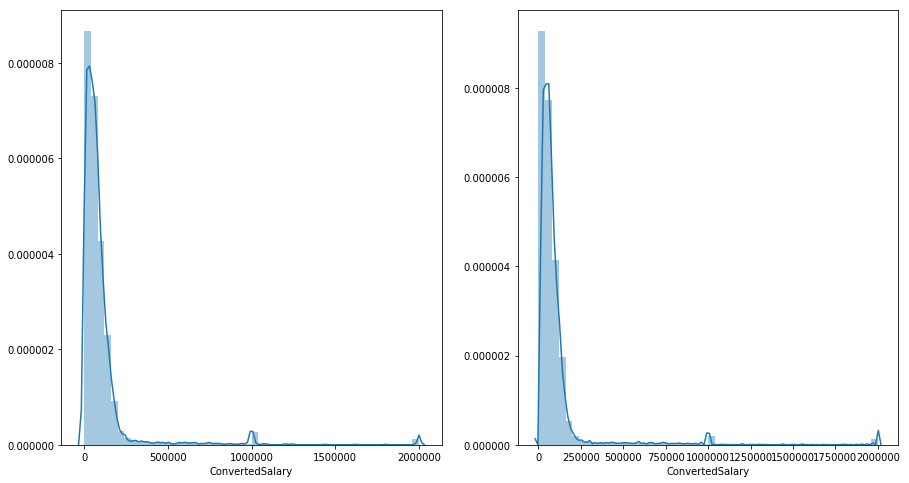

In [63]:
# Plot the distributions of the 2018 numerical variable 'ConvertedSalary' for data scientists
# and other developers
base_color = sns.color_palette()[0]
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.distplot(data_scientists_2018_clean['ConvertedSalary'].dropna(), norm_hist = True, hist = True, color = base_color)
plt.subplot(1, 2, 2)
sns.distplot(other_devs_2018_clean['ConvertedSalary'].dropna(), norm_hist = True, hist = True)


In [64]:
# Find out how many observations there are for salaries exceeding USD 500,000 
print(data_scientists_2018_clean[data_scientists_2018_clean['ConvertedSalary'] > 500000].shape[0])
print(other_devs_2018_clean[other_devs_2018_clean['ConvertedSalary'] > 500000].shape[0])

# Drop observations where ConvertedSalary > 500,000
data_scientists_2018_ml = data_scientists_2018_clean[data_scientists_2018_clean['ConvertedSalary'] <= 500000]
other_devs_2018_ml = other_devs_2018_clean[other_devs_2018_clean['ConvertedSalary'] <= 500000]

# Impute median for ConvertedSalary NANs
data_scientists_2018_ml = data_scientists_2018_ml.fillna(data_scientists_2018_ml.median())
other_devs_2018_ml = other_devs_2018_ml.fillna(other_devs_2018_ml.median())

# Have a look at new number of observations
print(data_scientists_2018_ml.shape[0])
print(other_devs_2018_ml.shape[0])

121
1425
3641
41507


Looking at the converted salary for the 2018 data we can tell that most salaries in USD were somewhat below USD 500,000. Quite interestingly we can see a little spike at around the USD 1,000,000 mark.

With only about 121 and 1425 observations for the data scientists and the other developers data, respectively, exceeding this threshold there should be little harm in dropping these more extreme values. Let us then replace the remaining NANs with the median.

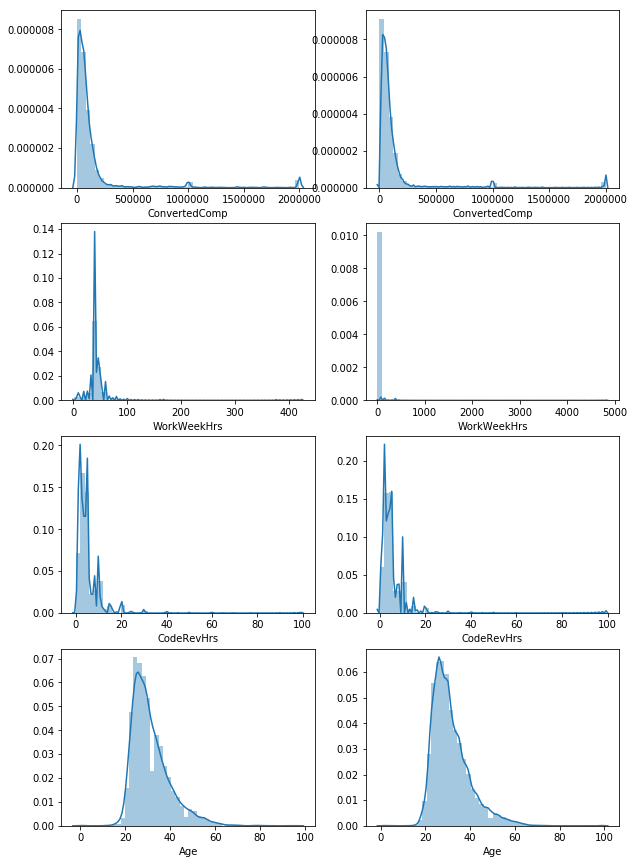

In [65]:
i = 0

plt.figure(figsize=(10,15))

rem_numerical_2019 = ['ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'Age']

for col in rem_numerical_2019:
    plt.subplot(4, 2, i+1)
    sns.distplot(data_scientists_2019_clean[col].dropna(), norm_hist = True, hist = True, color = base_color)
    plt.subplot(4, 2, i+2)
    sns.distplot(other_devs_2019_clean[col].dropna(), norm_hist = True, hist = True)
    i+=2

In [66]:
# Print numbers of observations affected by using thresholds for outliers discussed in Markdown cell below
# Also, apply these thresholds inside the same loop
thresholds_2019 = [500000, 80, 20, 65]

data_scientists_2019_ml = data_scientists_2019_clean.copy()
other_devs_2019_ml = other_devs_2019_clean.copy()

for col, threshold in zip(rem_numerical_2019,thresholds_2019): 
    print(data_scientists_2019_clean[data_scientists_2019_clean[col] > threshold].shape[0])
    print(other_devs_2019_clean[other_devs_2019_clean[col] > threshold].shape[0])
    data_scientists_2019_ml = data_scientists_2019_ml[data_scientists_2019_ml[col] <= threshold]
    other_devs_2019_ml = other_devs_2019_ml[other_devs_2019_ml[col] <= threshold]

# Use median for imputation
data_scientists_2019_ml = data_scientists_2019_ml.fillna(data_scientists_2019_ml.median())
other_devs_2019_ml = other_devs_2019_ml.fillna(other_devs_2019_ml.median())

# Show new numbers of observations
print(data_scientists_2019_ml.shape[0])
print(other_devs_2019_ml.shape[0])

247
2698
60
610
59
509
15
109
2484
33742


## Outliers 2019 Numerical Data
As for the ConvertedComp column we can observe a very similar pattern to what we found for the 2018 data. It again seems reasonable to only include observations with salariies below USD 500,000.

Using "common sense" I decided to drop all observations where the weekly work hours exceeded 80 hours. Indeed there may be cases of people who work 100 hours, but that would already be extreme outliers and hence should be excluded. This leads to the exclusion of 60 and 610 observations for the data scientists data and the other developers data. Note in this context that the graph for the other developers data looks rather strange due to some extreme outliers which do not make any sense and must have thus been entered in error.

Looking at the distribution and considering that on average a person's number of hours worked per week will usually be around 40 hours it makes sense to only exclude observations of people spending more than 20 hours per work on code review. As a consequence, observations will be dropped for the data scientists data and for the other developers data.

Finally, as far as the age of the respondents is concerned it probably makes sense to only include respondents below about 65 years since retirement age in many regions tends to be around 60 and 65. The distribution also suggests that respondents above 65 years were very rare.


## Imputation 2019 Numerical Data

It turns out that all of the above distributions are not quite symmetric. So it may be safer to use the median instead of the mean for our imputations.

Let us apply standardisation to all numerical columns.

In [67]:
# Standardise all numerical columns
# Identify numerical columns using approach outlined at 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas

numerical_columns_2018 = ['ConvertedSalary']
numerical_columns_2019 = ['ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'Age']

j = 0

for data in [data_scientists_2018_ml, other_devs_2018_ml, data_scientists_2019_ml, other_devs_2019_ml]:
    scaler = StandardScaler()
    if j < 2:
        cols = numerical_columns_2018
    else:
        cols = numerical_columns_2019
    data[cols] = scaler.fit_transform(data[cols])
    j+=1

## Additional Final Data Cleaning Steps

As an additional step, let us only consider respondents who are in some way working. For other groups such as students, unemployed and retirees there may not be that much use in identifying the driving factors behind their career satisfaction.

In [68]:
# Filter for respondents who are not students nor unemployed or retired for different years

i = 0

for col in ['University_No', 'EmploymentStatus_I prefer not to say', 'EmploymentStatus_Not employed, and not looking for work',
             'EmploymentStatus_Not employed, but looking for work', 'EmploymentStatus_Retired']:
    if i == 0:
        data_scientists_2017_clean = data_scientists_2017_clean[data_scientists_2017_clean[col]==1].drop([col], axis = 1)
        other_devs_2017_clean = other_devs_2017_clean[other_devs_2017_clean[col] == 1].drop([col], axis = 1)
    else:
        data_scientists_2017_clean = data_scientists_2017_clean[data_scientists_2017_clean[col] == 0].drop([col], axis = 1)
        other_devs_2017_clean = other_devs_2017_clean[other_devs_2017_clean[col] == 0].drop([col], axis = 1)
    i+=1


i = 0

for col in ['Student_No', 'Employment_Not employed, and not looking for work', 'Employment_Not employed, but looking for work',
            'Employment_Retired']:
    if i == 0:
        data_scientists_2018_ml = data_scientists_2018_ml[data_scientists_2018_ml[col] == 1].drop([col], axis = 1)
        other_devs_2018_ml = other_devs_2018_ml[other_devs_2018_ml[col] == 1].drop([col], axis = 1)
    else:
        data_scientists_2018_ml = data_scientists_2018_ml[data_scientists_2018_ml[col]== 0].drop([col], axis = 1)
        other_devs_2018_ml = other_devs_2018_ml[other_devs_2018_ml[col] == 0].drop([col], axis = 1)
    i+=1

i = 0
    
for col in ['Student_No','Employment_Not employed, but looking for work']:
    if i == 0:
        data_scientists_2019_ml = data_scientists_2019_ml[data_scientists_2019_ml[col] == 1].drop([col], axis = 1)
        other_devs_2019_ml = other_devs_2019_ml[other_devs_2019_ml[col] == 1].drop([col], axis = 1)
    else:
        data_scientists_2019_ml = data_scientists_2019_ml[data_scientists_2019_ml[col] == 0].drop([col], axis = 1)
        other_devs_2019_ml = other_devs_2019_ml[other_devs_2019_ml[col] == 0].drop([col], axis = 1)
    i+=1
    

# Modelling to Answer Questions

Now that the data cleaning and preparation has been completed we can finally turn to answering our 3 questions.

Questions 1 and 2 will be answered without use of machine learning and instead be based upon visualising distributions of the respondents' answers across time to find out if data scientists consistently differ from other developers with respect to their programming language use/ preference and educational background.

This then sets the stage for the final question where we will try to identify whether being a successful depends upon different than being a successful "regular developer". For this purpose, a decision tree algorithm will be used due to its comparatively good interpretability. 

## Question 1: Do Data Scientists Use Different Languages than Developers in General?

In order to answer the first question we will need to use inferential statistics. 

In addition to comparing the most recent data it may also be interesting to look at whether possible differences between the group of data scientists and other developers are persistent across time. The actual usage of programming languages by data scientists and other developers is captured in the column where respondents mentioned the languages they used during the previous year (as of the point in time at which they answered the survey). Another column in which respondents were asked to mention the languages they would like to use in the next year following the survey can be thought of as capturing developers' personal preferences and may thus also provide useful information for this analysis. It may thus make sense to look at both of these columns.

In [69]:
# sort dataframes by frequencies of languages in 2019
dev_ds_worked_top10 =dev_ds_language_worked.sort_values('2019', ascending = False).iloc[:10]
dev_ds_des_top10 = dev_ds_language_desired.sort_values('2019', ascending = False).iloc[:10]
dev_non_ds_worked_top10 = dev_non_ds_language_worked.sort_values('2019', ascending = False).iloc[:10]
dev_non_ds_des_top10 = dev_non_ds_language_desired.sort_values('2019', ascending = False).iloc[:10]

# Sort the non-developer data by frequencies of languages worked with
non_dev_ds_languages_top10 = non_dev_ds_languages.sort_values('Worked with', ascending = False).iloc[:10]
non_dev_languages_top10 = non_dev_languages.sort_values('Worked with', ascending = False).iloc[:10]

# reshape dataframes for subsequent use with seaborn
# using approach found at https://stackoverflow.com/questions/52067785/seaborn-bar-chart-for-categorical-data-grouped

dev_ds_work_melt = pd.melt(dev_ds_worked_top10.reset_index(), id_vars = ['index'],value_vars = dev_ds_worked_top10.columns)
dev_ds_des_melt = pd.melt(dev_ds_des_top10.reset_index(), id_vars = ['index'],value_vars = dev_ds_worked_top10.columns)
dev_non_ds_work_melt = pd.melt(dev_non_ds_worked_top10.reset_index(), id_vars = ['index'],
                               value_vars = dev_ds_worked_top10.columns)
dev_non_ds_des_melt = pd.melt(dev_non_ds_des_top10.reset_index(), id_vars = ['index'],
                              value_vars = dev_ds_worked_top10.columns)

non_dev_ds_languages_melt = pd.melt(non_dev_ds_languages_top10.reset_index(), id_vars = ['index'],
                                    value_vars = non_dev_ds_languages_top10.columns)

non_dev_languages_melt = pd.melt(non_dev_languages_top10.reset_index(), id_vars = ['index'],
                                 value_vars = non_dev_languages_top10.columns)

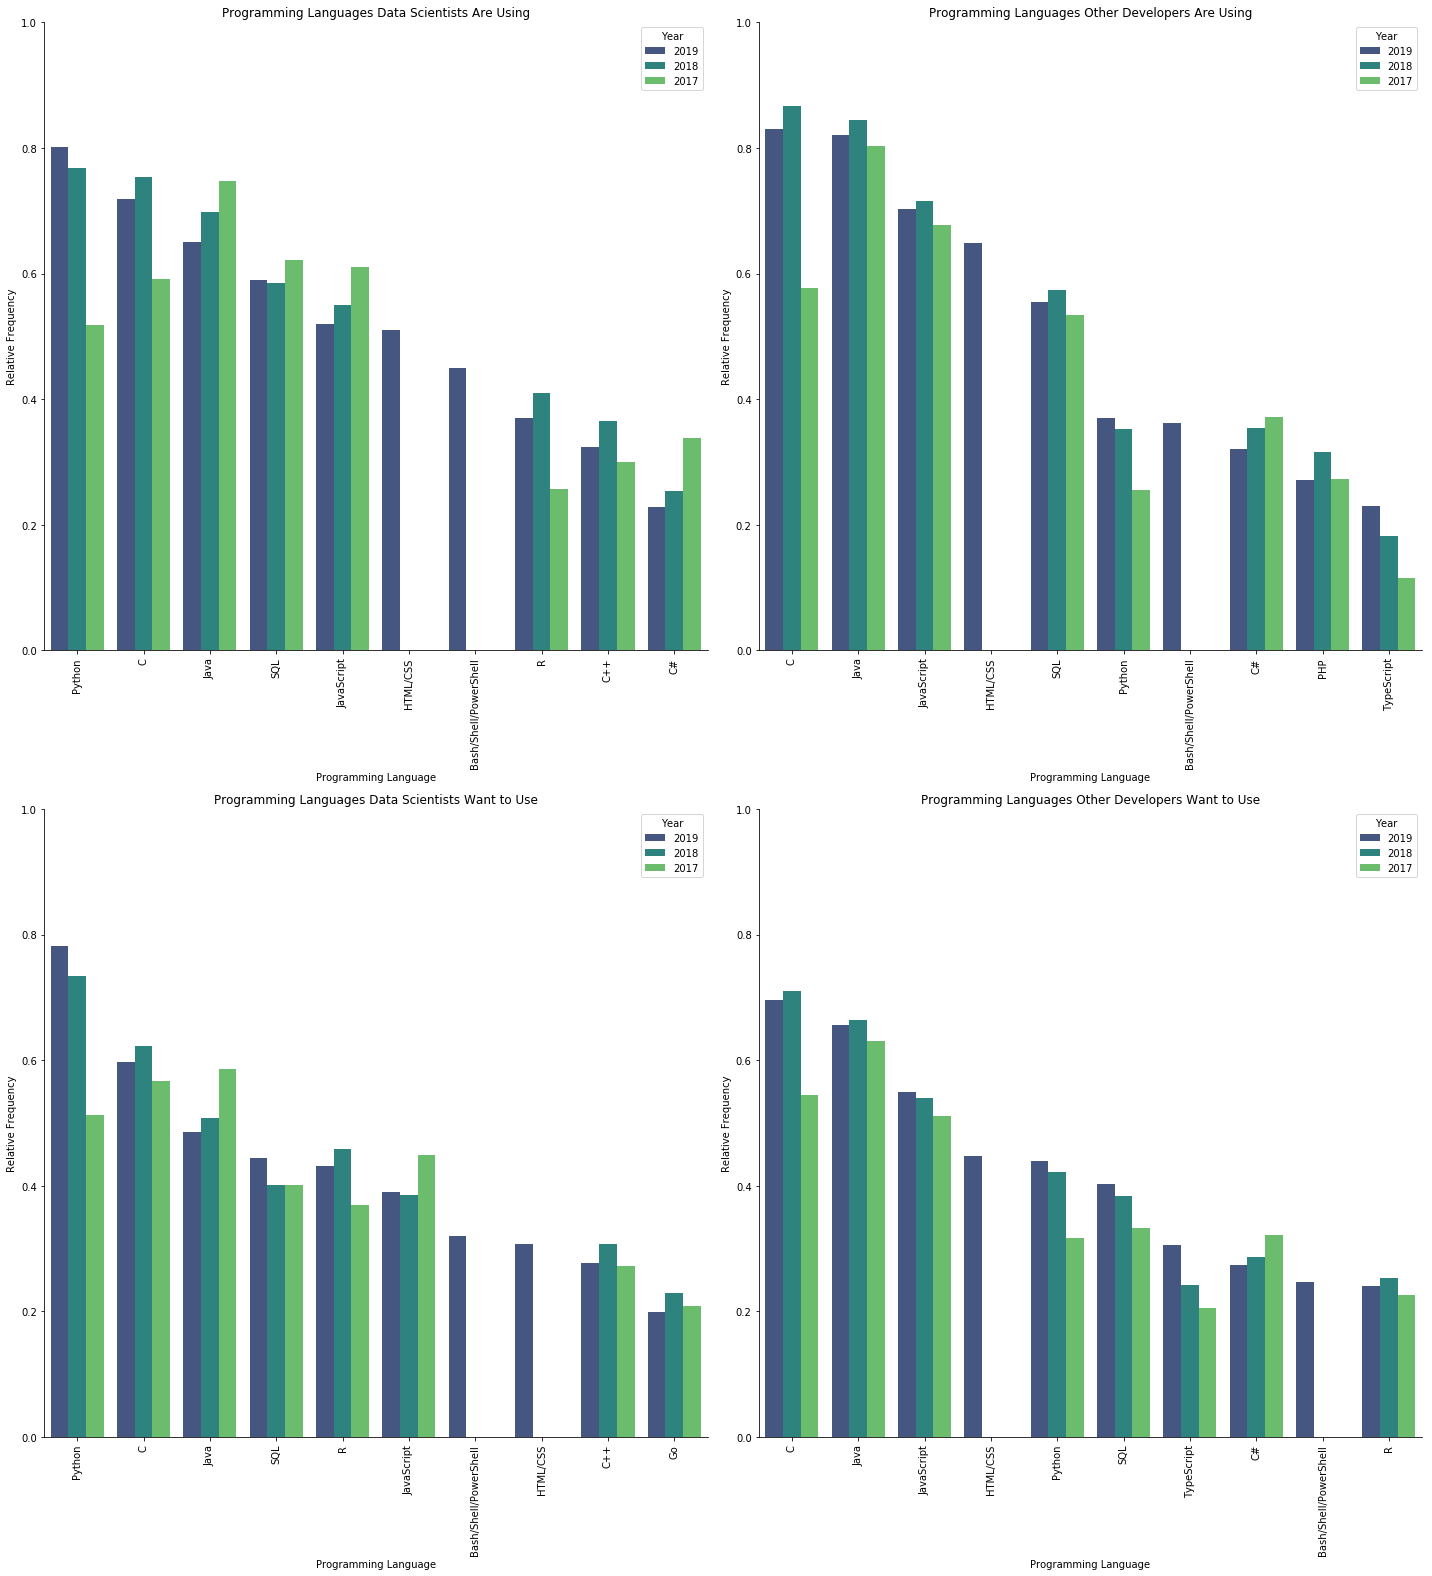

In [73]:
# Define order of categories, i.e. years
year_order = ['2019', '2018', '2017']

# Define plot size
plt.figure(figsize=(20, 22))

# Adjust Subplot Layout

plt.subplots_adjust(hspace = 0.9)

i = 1

for df in [dev_ds_work_melt,dev_non_ds_work_melt,dev_ds_des_melt,dev_non_ds_des_melt]:
    plt.subplot(2,2,i)
    plt.subplots_adjust(hspace = 0.9)
    myplot = sns.barplot(x = 'index', y = 'value', hue='variable', hue_order = year_order, data = df,
                     palette = 'viridis')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=90);
    myplot.set(xlabel = 'Programming Language', ylabel = 'Relative Frequency');
    plt.legend(title = 'Year');
    sns.despine(right=True,top=True)
    
    if i %2 == 0:
           group = 'Other Developers'
    else:
           group = 'Data Scientists'
           
    if i > 2:
        title_des_work = 'Want to Use'
    else:
        title_des_work = 'Are Using'       
    plt.title('Programming Languages '+group+' '+title_des_work)
    plt.yticks(np.arange(0.0,1.2,0.2))
    plt.savefig('devs_programming_languages'+str(i)+'.png', bbox_inches = 'tight')
    i+=1
    
plt.tight_layout()
plt.show()

## Brief Summary of Findings

Looking at the above graphs we can see that there are significant differences in the languages data scientists are using and want to use as compared to other developers. One caveat here is that the relative shares of the individual languages were quite different in 2017, but that also holds true for other developers. Indeed, for both groups Java was the most often used programming language in 2017.

Leaving aside the peculiarities of the 2017 data, the programming language used most often and also most popular with data scientists is Python with a share of about 80% of the respondents using it in 2019. As for other developers, they are using C most often (slighty above 80%) and they are also most fond of it. It is closely followed by Java with an almost equal usage ratio. Javascript comes in third at around 70%. In the case of data scientists C is on the second place (72%) and Java (65%) on the third one.

As one would probably expect R also seems to be used significantly more often by data scientists where it shows up at the 8th place (37%) while for the other developers it did not make it into the top 10 due its low usage ratio of just 14.2%. Interestingly, R does better in terms of popularity than actual usage both with respect to data scientists (43%) and other developers (24%).

As for how constant these findings are, the order of the rankings is virtually the same in both 2019 and 2018 while relative frequencies differ a bit. As mentioned above, 2017 is quite a bit different. This could partly be due to the fact that participants were given the opportunity to identify themselves as non-developers. We created separate dataframes for them which we will have a brief look at below. Another thing to note here is that Bash/ Shell/ PowerShell and HTML/CSS only show up for the 2019 data because they were included in other questions in the 2018 and 2017.

## Interpretation

Overall, the differences between data scientists and other developers here are not quite as pronounced as I would have expected based on the job advertisements I have read over time. It is not immediately obvious whether this is simply due to my expectations being biased. Other possible explanations could include a sort of self-selection bias with respect to those who took the Stackoverflow Developer Surveys. Maybe even those participants who identify themselves are more likely to be "full-fledged" developers than would be the case for the overall population of data scientists. A brief look at the 2017 data for data scientists and other developers who did not identify themselves as developers could provide some evidence.

## How About Non-Developers? (2017 Data Only)

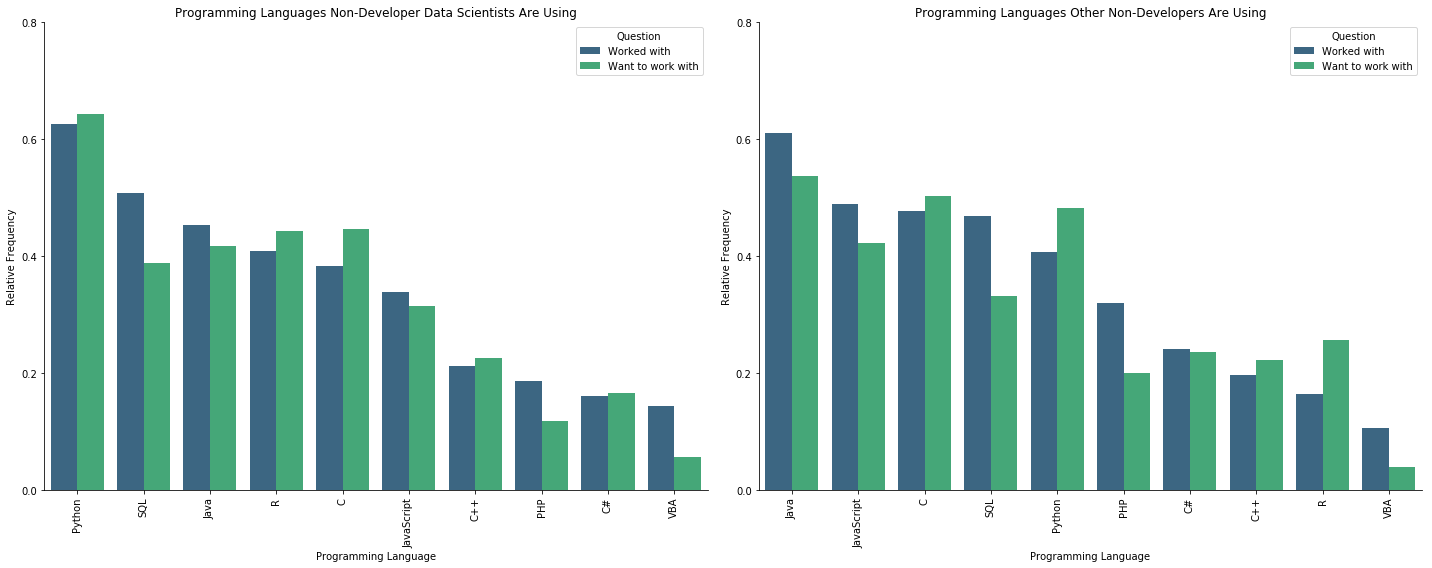

In [74]:
# define plot size
plt.figure(figsize=(20,8))

i = 1

for df in [non_dev_ds_languages_melt, non_dev_languages_melt]:
    plt.subplot(1,2,i)
    myplot = sns.barplot(x = 'index',y = 'value',hue='variable', data = df,
                     palette = 'viridis')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation = 90);
    myplot.set(xlabel = 'Programming Language', ylabel = 'Relative Frequency');
    plt.legend(title = 'Question');
    sns.despine(right = True,top = True)
    
    if i %2 == 0:
           group = 'Other Non-Developers'
    else:
           group = 'Non-Developer Data Scientists'
           
    if i > 2:
        title_des_work = 'Want to Use'
    else:
        title_des_work = 'Are Using'       
    plt.title('Programming Languages '+group+' '+title_des_work)
    plt.yticks(np.arange(0.0,1.0,0.2))
    plt.savefig('non_devs_programming_languages'+str(i)+'.png', bbox_inches = 'tight')
    i+=1
    
plt.tight_layout()
plt.show()

We see that overall usage ratios and the desire to work with indivdual languages is significantly lower than in the case of those respondents who identified as developers.

Non-developer data scientists used Python most often (63%) as did their developer counterparts. More interestingly, SQL placed second (51%) followed by Java (45%) and R (41%) which was ahead of C (38%). This is actually more in line with the subjective impressions I have had from reading data scientist job advertisements.

As for the other non-developers, their most often used languages are Java(61%), JavaScript(49%), C (48%), SQL (47%) and Python (41%). In terms of languages non-developers want to work with, C (50%) even places second only slighty behind Java (54%). Python follows very closely with 48%.

Even so, it is interesting to see that even if the analysis is only restricted to non-developers more "hardcore" languages such as C or C++ enjoy a significant following. One might expect that data scientists in general and in particular those who do not consider themselves developers are noticeably less likely to use them than other developers.

## Question 2: Do Data Scientists Tend to Have Different Educational Backgrounds than Other Developers?

As the next step, let us have a look at the educational backgrounds of data scientists and other developers. For the sake of brevity and simplicity, non developer data will not be considered here.

This question can be answered in a similar way as question 2 by creating a categorical bar chart and interpreting the results. We can essentially use the same code as above.

In [75]:
# Sort dataframe cotanining formal education and major value counts by frequencies in 2019
ds_formed_top10 =ds_formed.sort_values('2019', ascending = False).iloc[:10]
other_devs_formed_top10 = other_devs_formed.sort_values('2019', ascending = False).iloc[:10]
ds_majors = ds_majors.sort_values('2019', ascending = False)
other_devs_majors = other_devs_majors.sort_values('2019', ascending = False)

# As above, apply pd.melt to convert dataframes such that they can be used with seaborn
ds_formed_melt = pd.melt(ds_formed_top10.reset_index(), id_vars = ['index'], value_vars = ds_formed_top10.columns)
other_devs_formed_melt = pd.melt(other_devs_formed_top10.reset_index(), id_vars = ['index'],
                                 value_vars = other_devs_formed_top10.columns)
ds_majors_melt = pd.melt(ds_majors.reset_index(), id_vars = ['index'], value_vars = ds_majors.columns)
other_devs_majors_melt = pd.melt(other_devs_majors.reset_index(), id_vars = ['index'],
                                 value_vars = other_devs_majors.columns)

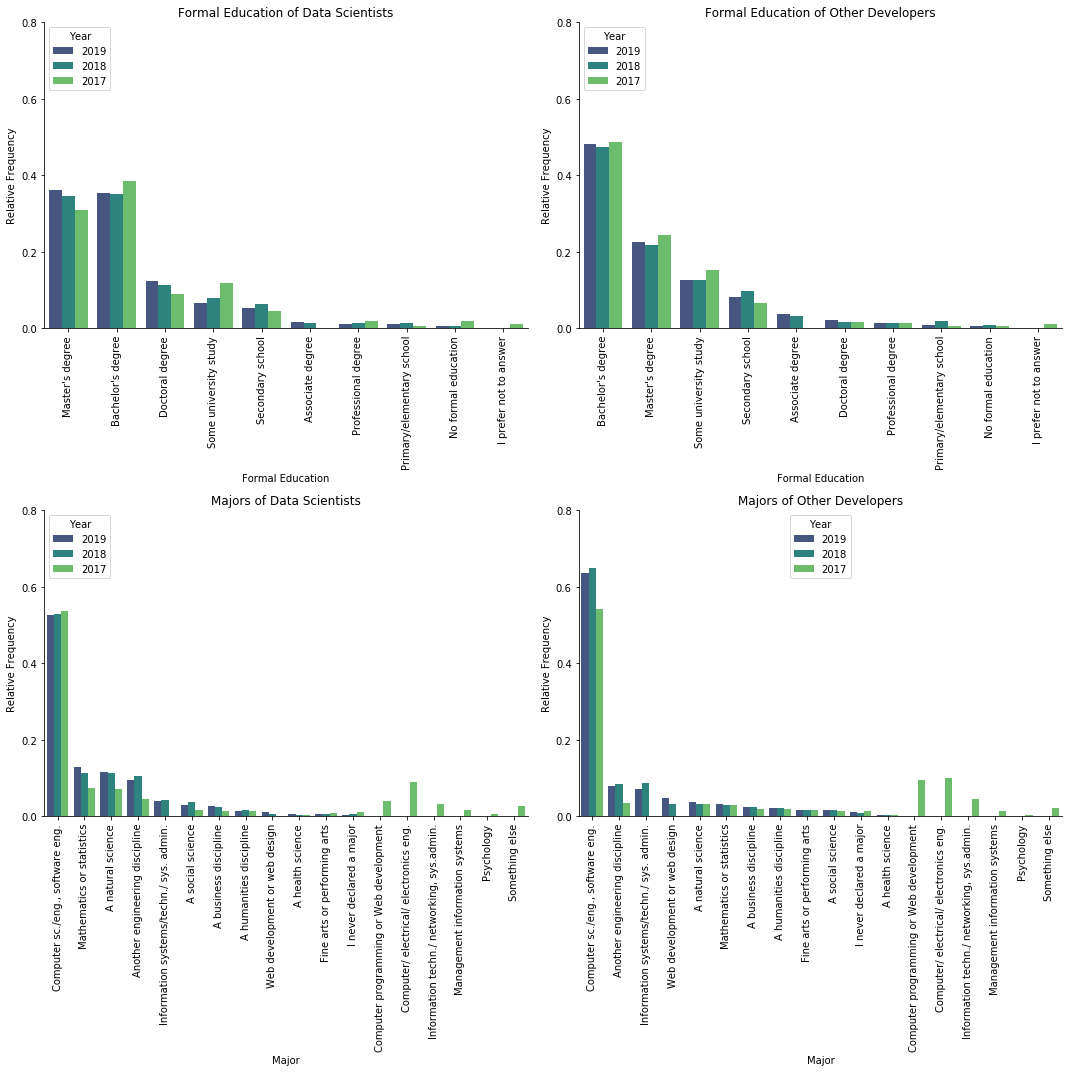

In [76]:
# define plot size
plt.figure(figsize=(15, 15))

i = 1

for df in [ds_formed_melt,other_devs_formed_melt,ds_majors_melt,other_devs_majors_melt]:
    plt.subplot(2, 2, i)
    myplot = sns.barplot(x = 'index', y = 'value', hue = 'variable', hue_order = year_order, data = df,
                     palette = 'viridis')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation = 90);
    if i <= 2:
        myplot.set(xlabel = 'Formal Education', ylabel = 'Relative Frequency');
    else:
        myplot.set(xlabel = 'Major', ylabel = 'Relative Frequency')
    plt.legend(title='Year');
    sns.despine(right = True,top = True)
    
    if i %2 == 0:
           group = 'Other Developers'
    else:
           group = 'Data Scientists'
           
    if i > 2:
        title_des_work = 'Majors of '
    else:
        title_des_work = 'Formal Education of '       
    plt.title(title_des_work+group)
    plt.yticks(np.arange(0.0, 1.0, 0.2))
    plt.savefig('education_devs'+str(i)+'.png', bbox_inches = 'tight')
    i+=1
    
plt.tight_layout()
plt.show()

## Formal Education

Let us first look at the patterns for the 2019 data.

As far as the formal education is concerned, there seems to be a significant difference between data scientists and other developers. In the case of data scientists both master's degrees and bachelor's degrees are held by roughly 1/3 of the respondents each with master's degrees accounting for a slightly larger share. In contrast to this, almost 1/2 of the other developers (48%) have a bachelor's degree and only about 1/5 (23%) hold a master's degree. It is also rather interesting that about 1/8 (12%) of the respondents who identified as data scientists had a doctoral degree while only 2% of the other developers had such a degree. In the case of other developers, roughly 1/8 of the respondents reported having only completed some university study without obtaining a degree. Other types of degrees accounted only for a minor share.

While these observations refer to 2019, but the patterns also hold true for 2018. Again, the 2017 data is a bit different with e.g. the share of holders of a bachelor's degree slightly exceeding that of those with a master's degree.

Even so across all three years, we can observe that data scientists tend to have a higher level of formal education as compared to other developers.

## Majors

The differences with respect to the majors chosen by data scientists and other developers are more subtle. Across all three years and across both groups the largest share can be attributed to computer science majors for both data scientists (53%) and other developers(64%). The most notable difference apart from the the smaller share of computer science majors is that maths/ statistics majors and natural science majors account for a combined share of about 1/4 (24%) when it comes to data scientists, but only for as little as about 7% of other developers.

This pattern also holds true for 2018 and to a lesser degree for 2017, but even there maths/ statistics and natural science majors account for twice as high a share as in the case of other developers.

Overall, we can see that while data scientists also mostly have a computer science background, maths/statistics and natural sciences also account for a noticeable share. Regardless of the exact proportions this is in line with what I would have expected. After all, data science is a subject that can be both interesting to people with a classic maths/ statistics or in other ways analytical and maths driven background while it obviously also appealing to people with a computer science background.

With that said, I do find it surprising that computer science majors account for such a large share. This may be indicative of the overall population of data scientists or could be due to a self-selection bias of those who decided to take the Stack Overflow surveys.

# Question 3: Does being successful/ being satisfied with one's career as a data scientist depend upon factors than being successful as a "normal" developer?



For the sake of brevity I am only going to test two models, a simple logistic regression and an AdaBoostClassifier and then choose the one with the better F-score. I am also going to limit this evaluation to the 2019 data and then train the chosen model on the 2018 and the 2017 data. Finally, for each one of the 3 years and each one of the two groups, data scientists and non-data scientists, I am going to look at the 5 most important features. 

Compared to a proper machine learning project this represents a simplified approach, but I believe it is justifiable since the question is about identifying important factors rather than obtaining a model to be used subsequently for new predictions.  

Before evaluating the two machine learning models let us check for imbalances in the target class and deal with them if necessary.

In [77]:
# Check for imbalances in target variable

j = 0

for data in [data_scientists_2019_ml, other_devs_2019_ml, data_scientists_2018_ml, other_devs_2018_ml, 
             data_scientists_2017_clean, other_devs_2017_clean]:
    if j < 2:
        target = 'CareerSat'
    else:
        target = 'CareerSatisfaction'
    
    print(data[target].value_counts(normalize=True))
    j+=1


1    0.807732
0    0.192268
Name: CareerSat, dtype: float64
1    0.79425
0    0.20575
Name: CareerSat, dtype: float64
1    0.795894
0    0.204106
Name: CareerSatisfaction, dtype: float64
1    0.771453
0    0.228547
Name: CareerSatisfaction, dtype: float64
1    0.873453
0    0.126547
Name: CareerSatisfaction, dtype: float64
1    0.874698
0    0.125302
Name: CareerSatisfaction, dtype: float64


It turns out that regardless of the year and the group we are considering there is a significant imbalance in the target variable. 

Let us try to remedy this by randomly upsampling the minority class, i.e. developers who are not satisfied with their career. Note that another issue we may face, if we do not do this is that our (hopefully) sophisticated model may be outperformed (in terms of accuracy) by a naive predictor which would just predict everything as belonging to the dominant class.  

In [78]:
# Use approach found at https://elitedatascience.com/imbalanced-classes
# Define function to obtain new dataframes with upsampled minority data

def upsample_minority(df, col, random_state = 64):

    # Separate majority and minority classes
    df_majority = df[df[col]==1]
    df_minority = df[df[col]==0]
    
    difference = df_majority.shape[0] - df_minority.shape[0]
 
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=difference,# to match majority class
                                     random_state=64) # reproducible results
 
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    return df_upsampled
    
data_scientists_2019_bal = upsample_minority(data_scientists_2019_ml, 'CareerSat')
other_devs_2019_bal = upsample_minority(other_devs_2019_ml, 'CareerSat')
data_scientists_2018_bal = upsample_minority(data_scientists_2018_ml, 'CareerSatisfaction')
other_devs_2018_bal = upsample_minority(other_devs_2018_ml, 'CareerSatisfaction')
data_scientists_2017_bal = upsample_minority(data_scientists_2017_clean, 'CareerSatisfaction')
other_devs_2017_bal = upsample_minority(other_devs_2017_clean, 'CareerSatisfaction')

We now have data sets with an equal proportion of both satisfied and unsatisfied respondents. This will help us in obtaining a trained model without too much of a bias.

Before moving on to evaluating the two machine learning algorithms let us make sure we first drop some of the more "obscure" dummy variables. If we do not do that, we may very well end up with some "obscure" features being attributed a much higher relevance than they actually deserve. I decided to set a threshold of at least 5% of observations having a value of 1, i.e. true, for a dummy.  

In [79]:
# Define a function to go through all columns of a dataframe and drop them based upon a significance criterion, i.e. number of
# observations with a value of 1

def select_one_hot_cols(df, cols, significance = 0.05):
    '''
    Drops dummy columns where less than the specified share of observations has a value of 1.
    Input:
        df - a pandas dataframe containing the data with the dummy columns
        cols - a list of the dummy columns to check and possibly drop
        significance - required share of observations having a value of 1 for dummy columns
                       not to be dropped
    Output:
        data - a new dataframe where the dummy columns not meeting the significance criterion
               were dropped
    '''
    
    threshold = int(round(significance*df.shape[0]))
    data = df.copy()
    for col in cols:
        if data[data[col] == 1].shape[0] < threshold:
            data = data.drop([col], axis = 1)
    return data

# Apply function to all relevant dataframes, but first identify relevant columns by removing numerical columns
# from list of all columns

one_hot_2019 = list(data_scientists_2019_bal.columns.drop(numerical_columns_2019))
one_hot_2018 = list((data_scientists_2018_bal.columns).drop(numerical_columns_2018))
one_hot_2017 = list(data_scientists_2017_bal.columns)

data_scientists_2019_bal = select_one_hot_cols(data_scientists_2019_bal, one_hot_2019)
other_devs_2019_bal = select_one_hot_cols(other_devs_2019_bal, one_hot_2019)
data_scientists_2018_bal = select_one_hot_cols(data_scientists_2018_bal, one_hot_2018)
other_devs_2018_bal = select_one_hot_cols(other_devs_2018_bal, one_hot_2018)
data_scientists_2017_bal = select_one_hot_cols(data_scientists_2017_bal, one_hot_2017)
other_devs_2017_bal = select_one_hot_cols(other_devs_2017_bal, one_hot_2017)

In [80]:
# Create train and test sets as in the Udacity 'Introduction to Data Science' class
# Split into X and Y, i.e. target and explanatory variables
def split_train_test(df, target, test_size):
    X = df.drop([target], axis = 1)
    y = df[target]
    # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 64)
    return X_train, X_test, y_train, y_test


# Define a function to easily obtain the model and results for different years
# I'm following the approach taken in the Udacity Data Scientist Nanodegree CharityMl project
def model_train_results(model, X_train, y_train, X_test, y_test):
    '''
    Trains a given classifier using the specified training and test data,
    calculates accuracy and F-score, returns the trained model and the
    scoring results
    Inputs:
    model - scikit learn classifier to be used for prediction and scoring
    X_train - features training data
    y_train - target variable training data
    X_test - features test data
    y_test - target variable test data
    Output:
    results - a dictionary containing the accuracy and f1 score of the trained model
    model_trained - the trained classifier
    '''
    results = {}
    # Train classifier and make predictions
    model_trained = model.fit(X_train, y_train)
    test_predictions = model_trained.predict(X_test)
    train_predictions = model_trained.predict(X_train)
    
    # Compute accuracy and F-score for both training and test data
    results['acc_train'] = accuracy_score(y_train, train_predictions)
    results['acc_test'] = accuracy_score(y_test, test_predictions)
    results['f_train'] = fbeta_score(y_train, train_predictions, beta = 0.5)
    results['f_test'] = fbeta_score(y_test, test_predictions, beta = 0.5)
    
    return model_trained, results
    
    
    
# Instantiate Models and obtain scores for the different models for the 2019 data scientists and
# other developers data

for data in [data_scientists_2019_bal, other_devs_2019_bal]:
    X_train,X_test,y_train,y_test = split_train_test(data, 'CareerSat', 0.3)
    ada_clf = AdaBoostClassifier(random_state = 64)
    ada_clf, ada_results = model_train_results(ada_clf, X_train, y_train, X_test, y_test);
    logreg_clf = LogisticRegression(random_state = 64)
    logreg_clf, logreg_results = model_train_results(logreg_clf, X_train, y_train, X_test, y_test);
    print('AdaBoost results:\n')
    print(ada_results)
    print('\n Logistic regression results:\n')
    print(logreg_results)

C:\Users\hendrik\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AdaBoost results:

{'acc_train': 0.7365424430641822, 'acc_test': 0.6936067551266586, 'f_train': 0.7628465477662016, 'f_test': 0.7264610389610389}

 Logistic regression results:

{'acc_train': 0.755175983436853, 'acc_test': 0.6936067551266586, 'f_train': 0.7783060397957388, 'f_test': 0.7295150501672241}


C:\Users\hendrik\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AdaBoost results:

{'acc_train': 0.6577697433716149, 'acc_test': 0.6519725415598379, 'f_train': 0.6952452714803651, 'f_test': 0.6850718398257171}

 Logistic regression results:

{'acc_train': 0.6601446193109315, 'acc_test': 0.6574311471342321, 'f_train': 0.6974255991572295, 'f_test': 0.6894447041712118}


Judging from the above result there is not much of a difference in how well the two models perform. Overall, the logistic regression seems to have a slight edge over the AdaBoost classifier. Let us therefore use it to identify the most important variables in predicting the career satisfaction of data scientists and other developers.

# Identifying the Most Important Features for Predicting Career Satisfaction

Given the large number of features in our dataframes, it makes sense to use some sort of feature selection. One popular approach would be Principle Components Analysis (PCA). I instead decided to use Recursive Feature Selection which along with other feature selection methods (including PCA) is discussed at https://machinelearningmastery.com/feature-selection-machine-learning-python/.

Before doing so we need to split our data into test and training sets. We can then perform feature selection using Recursive Feature Elimination. Finally, we can look at the coefficients to determine the direction of the effect of each of the variables on the probability of someone being satisfied with their career. 

In [81]:
# Obtain train and test data used for training selected model for 2019, 2018 and 2017 data
X_train_19_ds,X_test_19_ds,y_train_19_ds,y_test_19_ds = split_train_test(data_scientists_2019_bal, 'CareerSat', 0.3)
X_train_19_devs,X_test_19_devs,y_train_19_devs,y_test_19_devs = split_train_test(other_devs_2019_bal, 'CareerSat', 0.3)

X_train_18_ds,X_test_18_ds,y_train_18_ds,y_test_18_ds = split_train_test(data_scientists_2018_bal, 'CareerSatisfaction', 0.3)
X_train_18_devs,X_test_18_devs,y_train_18_devs,y_test_18_devs = split_train_test(other_devs_2018_bal, 'CareerSatisfaction', 0.3)

X_train_17_ds,X_test_17_ds,y_train_17_ds,y_test_17_ds = split_train_test(data_scientists_2017_bal, 'CareerSatisfaction', 0.3)
X_train_17_devs,X_test_17_devs,y_train_17_devs,y_test_17_devs = split_train_test(other_devs_2017_bal, 'CareerSatisfaction', 0.3)


# Use approach found at https://machinelearningmastery.com/feature-selection-machine-learning-python/
# to obtain 10 most important features using logistic regression and recursive feature elimination (RFE)

def logreg_rfe(X_train, y_train, n):
    '''
    Identifies the most important n features for the training data via RFE using a logistic regression 
    and returns both the fitted RFE object containing the fitted logistic regression and a dataframe 
    with the n most important features and their coefficients
    Input:
    X_train - feature training data
    y_train - target training data
    n - number of features allowed for feature selection using RFE
    Output:
    coefficients - a dataframe containing the coefficients of the trained logistic regression model
    rfe - trained logistic regression
    '''
    logreg_clf = LogisticRegression(random_state = 64, solver = 'liblinear')
    rfe = RFE(logreg_clf, n)
    rfe = rfe.fit(X_train, y_train)
    feat = rfe.get_support(1)
    features = X_train.columns[feat]
    coefficients = pd.DataFrame({"Feature":features, "Coefficients":np.transpose(rfe.estimator_.coef_[0,])})
    return rfe, coefficients

# Define number of features to be used for RFE

num_feats = 10

# Apply this function to both groups for all three years
# PLEASE NOTE THIS MAY TAKE SOME TIME!

print('WARNING: Aplying RFE to all 6 training sets may take a while...')

rfe_19_ds, feat_19_ds = logreg_rfe(X_train_19_ds, y_train_19_ds, num_feats)
rfe_19_devs, feat_19_devs = logreg_rfe(X_train_19_devs, y_train_19_devs, num_feats)
rfe_18_ds, feat_18_ds = logreg_rfe(X_train_18_ds, y_train_18_ds, num_feats)
rfe_18_devs, feat_18_devs = logreg_rfe(X_train_18_devs, y_train_18_devs, num_feats)
rfe_17_ds, feat_17_ds = logreg_rfe(X_train_17_ds, y_train_17_ds, num_feats)
rfe_17_devs, feat_17_devs = logreg_rfe(X_train_17_devs, y_train_17_devs, num_feats)

print('Thank you for your patience. RFE has been applied to all training sets!')

# Have a look at the resulting dataframes with coefficients for 2019
print(feat_19_ds)
print(feat_19_devs)

Thank you for your patience. RFE has been applied to all training sets!
                                             Feature  Coefficients
0           UndergradMajor_Mathematics or statistics      0.524542
1                                     YearsCodePro_4      0.771326
2            JobSeek_I am actively looking for a job     -0.993534
3  JobSeek_I am not interested in new job opportu...      1.104257
4                      ImpSyn_A little above average      0.668412
5                           ImpSyn_Far above average      0.724720
6                                           Educator      0.663706
7                                Engineering manager      0.752673
8                                             Vue.js     -0.507592
9                                            Germany      0.720536
                                             Feature  Coefficients
0                                    YearsCodePro_47      0.461328
1            JobSeek_I am actively looking for a job     

In [82]:
# Have a short look at all column names to get an overview of which ones will need to be shortened
# before plotting the coefficients
feat_dfs = [feat_19_ds, feat_19_devs, feat_18_ds, feat_18_devs, feat_17_ds, feat_17_devs]

for df in feat_dfs:
    print(df['Feature'].tolist())
    print('\n')

['UndergradMajor_Mathematics or statistics', 'YearsCodePro_4', 'JobSeek_I am actively looking for a job', 'JobSeek_I am not interested in new job opportunities', 'ImpSyn_A little above average', 'ImpSyn_Far above average', 'Educator', 'Engineering manager', 'Vue.js', 'Germany']


['YearsCodePro_47', 'JobSeek_I am actively looking for a job', 'JobSeek_I am not interested in new job opportunities', 'ResumeUpdate_My job status changed (promotion, new job, etc.)', 'ImpSyn_A little above average', 'ImpSyn_Average', 'ImpSyn_Far above average', 'CodeRev_Yes, because I was told to do so', 'Containers_Development;I do not use containers', 'United States']


['Employment_Employed full-time', 'Employment_Independent contractor, freelancer, or self-employed', 'HopeFiveYears_Doing the same work', 'JobSearchStatus_I am actively looking for a job', 'JobSearchStatus_I am not interested in new job opportunities', 'EthicalImplications_No', "Exercise_I don't typically exercise", 'Dependents_No', 'Depende

We can now have the necessary dataframes to do a visualisation of the most important featurees for both groups for each of the
3 years. As we have seen above, some of the feature names are rather long. We will need to shorten them for our plots to look nice. So let us do this next and then plot the coefficients similar to what we have done above for questions 1 and 2.

In [84]:
# Define dictionaries for replacing overly long feature names
feat_rep_dict = {}

feat_19_rep = {'JobSeek_I am actively looking for a job':'actively looking for a job',
               'JobSeek_I am not interested in new job opportunities':'no interest in new job',
               'ImpSyn_A little above average':'competence_a little above average',
               'ImpSyn_Far above average':'competence_far above average',
               'ResumeUpdate_My job status changed (promotion, new job, etc.)':'ResumeUpdate_job status changed',
               'ImpSyn_Average':'competence_average', 'CodeRev_Yes, because I was told to do so':'CodeRev_told to do',
               'Containers_Development;I do not use containers':'ContainersDev_do not use'
              }
feat_18_rep = {'Employment_Independent contractor, freelancer, or self-employed':'Employment_independent',
               'HopeFiveYears_Doing the same work':'Hope doing same work in 5y',
               'JobSearchStatus_I am actively looking for a job':'actively looking for a job',
               'JobSearchStatus_I am not interested in new job opportunities':'no interest in new job',
               'EthicalImplications_No':'do not consider ethical implications', 'Exercise_I do not typically exercise':
               'do not typically exercise','AgreeDisagree1_Agree':'connection to other devs_agree',
               'AgreeDisagree1_Strongly agree':'connection to other devs_strongly agree',
               'HopeFiveYears_Working as a founder or co-founder of my own company':
               'hope work as founder/ co-founder in 5y',
               'HopeFiveYears_Working as a product manager or project manager':'hope work as product/ project mgr in 5y',
               'HopeFiveYears_Working as an engineering manager or other functional manager':
               'hope work as eng./oth. funct. mgr in 5y', 
               'HopeFiveYears_Working in a different or more specialized technical role than the one I\'m in now':
               'hope work different/ more specialized tech. in 5y'
              }
feat_17_rep = {'CompanyType_Government agency or public school/university':'work for govt. agcy/public school/uni',
               'JobSeekingStatus_I am actively looking for a job':'actively looking for a job', 
               'JobSeekingStatus_I am not interested in new job opportunities':'no interest in new job',
               'EducationImportant_Not at all important':'education_not all important',
               'ShipIt_Strongly disagree':'ship optimize later_Strongly disagree',
               'BuildingThings_Agree':'enjoy building things_Agree', 'UnderstandComputers_Somewhat agree':
               'limited knowledge PCs_Somewhat agree','UnderstandComputers_Strongly agree':
               'limited knowledge PCs_Strongly agree', 'UnderstandComputers_Strongly disagree':
               'limited knowledge PCs_Strongly disagree'
              }
                    
# Replace long feature names
feat_19_ds['Feature'] = feat_19_ds['Feature'].replace(feat_19_rep)
feat_19_devs['Feature'] = feat_19_devs['Feature'].replace(feat_19_rep)
feat_18_ds['Feature'] = feat_18_ds['Feature'].replace(feat_18_rep)
feat_18_devs['Feature'] = feat_18_devs['Feature'].replace(feat_18_rep)
feat_17_ds['Feature'] = feat_17_ds['Feature'].replace(feat_17_rep)
feat_17_devs['Feature'] = feat_17_devs['Feature'].replace(feat_17_rep)

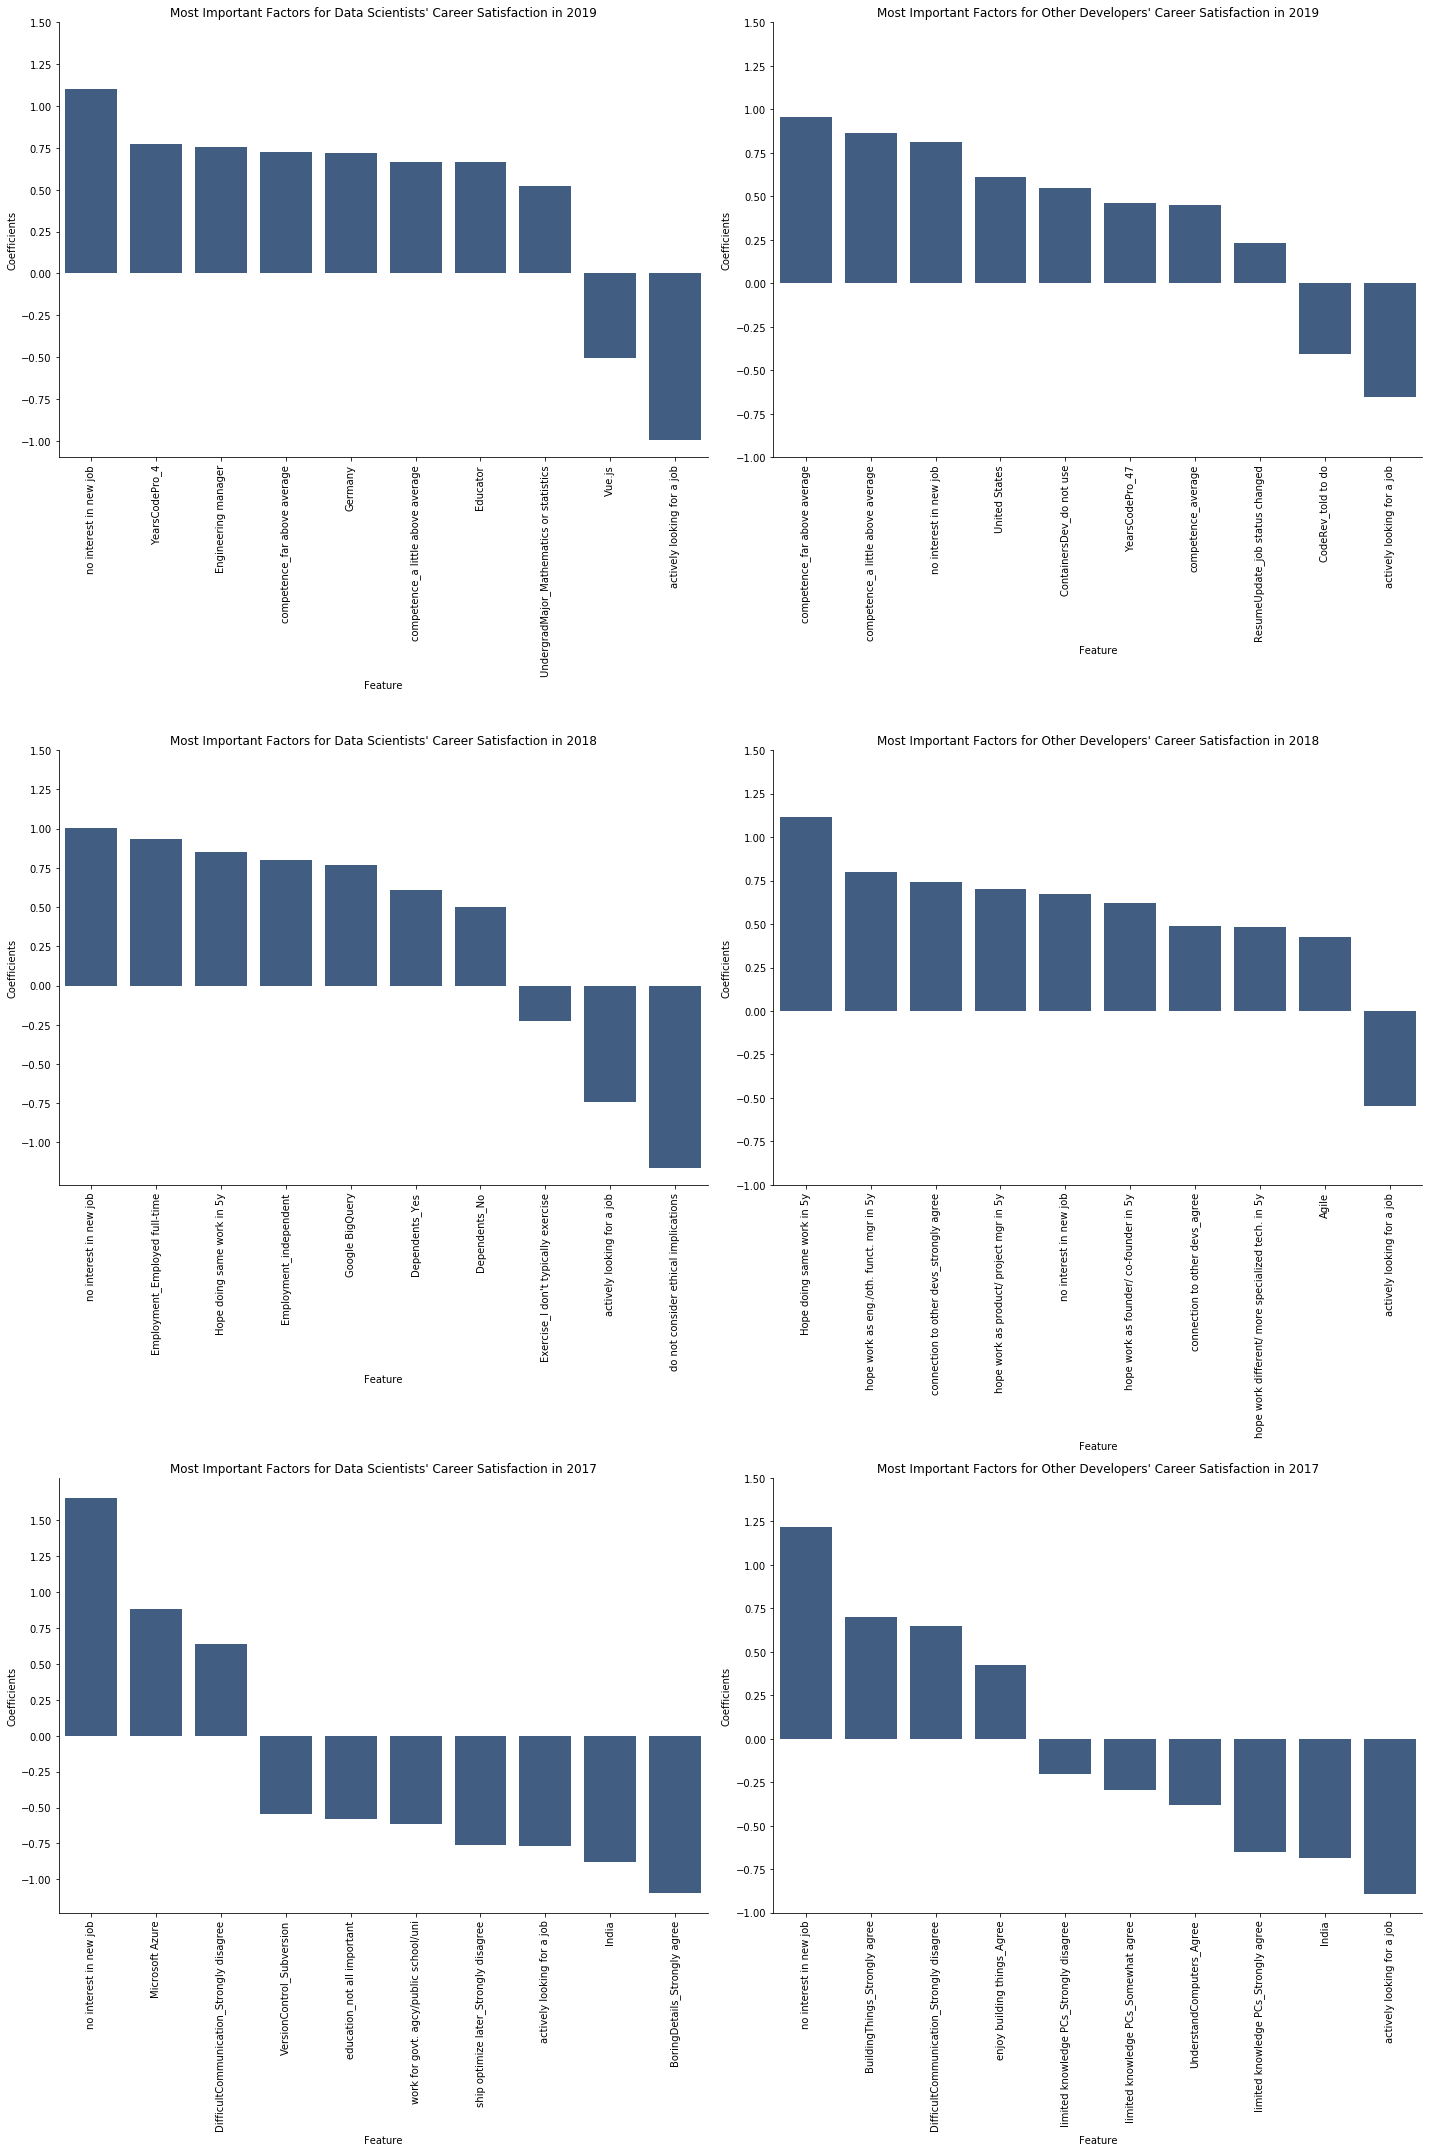

In [85]:
# Define plot size
plt.figure(figsize=(20,30))

# Choose colour to use for bars
bar_colour = sns.color_palette('viridis')[1]

i = 1

for df in feat_dfs:
    plt.subplot(3,2,i)
    df = df.sort_values(by=['Coefficients'], ascending = False)
    myplot = sns.barplot(x = 'Feature', y = 'Coefficients', data = df,
                     color = bar_colour)
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=90);
    sns.despine(right=True,top=True)
    
    if i %2 == 0:
           group = 'Other Developers\''
    else:
           group = 'Data Scientists\''
    if i < 3:
        year = '2019'
    if (i >= 3 and i < 5):
        year = '2018'
    if i >=5:
        year = '2017'
         
    plt.title('Most Important Factors for '+group+' Career Satisfaction in '+year)
    plt.yticks(np.arange(-1.0, 1.75, 0.25))
    plt.savefig('career_satisfaction_'+str(i)+'.png')
    i+=1
    
plt.tight_layout()
plt.show()

## Brief Interpretation of Results

The exact interpretation of the coefficients of a logistic regression may be somewhat difficult, but for our purposes here it is sufficient to essentially only take into consideration the magnitude (in absolute terms) and the direction (positive or negative) of a coefficient associated with a specific variable. A nice and short explanation can be found at https://stats.stackexchange.com/questions/342627/how-to-visualise-coefficients-of-a-binomial-logistic-regression.

Given the large differences in the list of the 10 most relevant features there may perhaps not be so much of a point in discussing each of the 6 bar charts above. Instead let us focus on some major takeaways.

Data scientists and other developers regardless of the year we are considering tend to be more satisfied with their career if they are not interested in new job opportunities and less so if they are actively looking for a new job. It also turns out that the direction of effects for common top 10 features tends to be identical across the two groups. Even so, we can observe for each year that there are noticeable differences in the 10 most important features. Career satisfaction of other developers seems to depend more on features more strongly associated with more core development or IT skills. A case in point would be the two containers and code review related features showing up only for 2019 other developers, but not for the data scientists. 

# Conclusion

Following a Crisp DM approach applied to Stack Overflow Developer Suvey data of the last 3 years (2017 to 2019) this Juypter notebook has shown that at least up to a certain degree data scientists do indeed differ from other developers.

* Their usage of programming languages differs, but they also use languages like C and Java quite frequently. 
* Data scientists are more likely to have an advanced degree and to have a non-IT/ computer science background. 
* Career satisfaction for data scientists and other developers depends partly on the same and partly on somewhat
different factors

Overall, perhaps as one might have suspected data scientists are not completely different from other developers, but in spite of certain differences also seem to a have significant number of things in common with other developers.